In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.image as mpimg
import matplotlib.patches as patches
import matplotlib as mpl
from mplsoccer import Pitch, VerticalPitch, FontManager, Sbopen, add_image
from matplotlib.font_manager import FontProperties
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.patheffects as path_effects
from highlight_text import ax_text, fig_text
from PIL import Image
from mplsoccer import add_image
from urllib.request import urlopen
import os
from statistics import mode


# Print the modified DataFrame
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

green = '#69f900'
red = '#ff4b44'
blue = '#00a0de'
violet = '#a369ff'
bg_color= '#f5f5f5'
line_color= '#000000'
col1 = '#ff4b44'
col2 = '#00a0de'

# LaLiga

In [41]:
df = pd.read_csv(r"D:\FData\LaLiga_2024_25\till_gw13.csv")

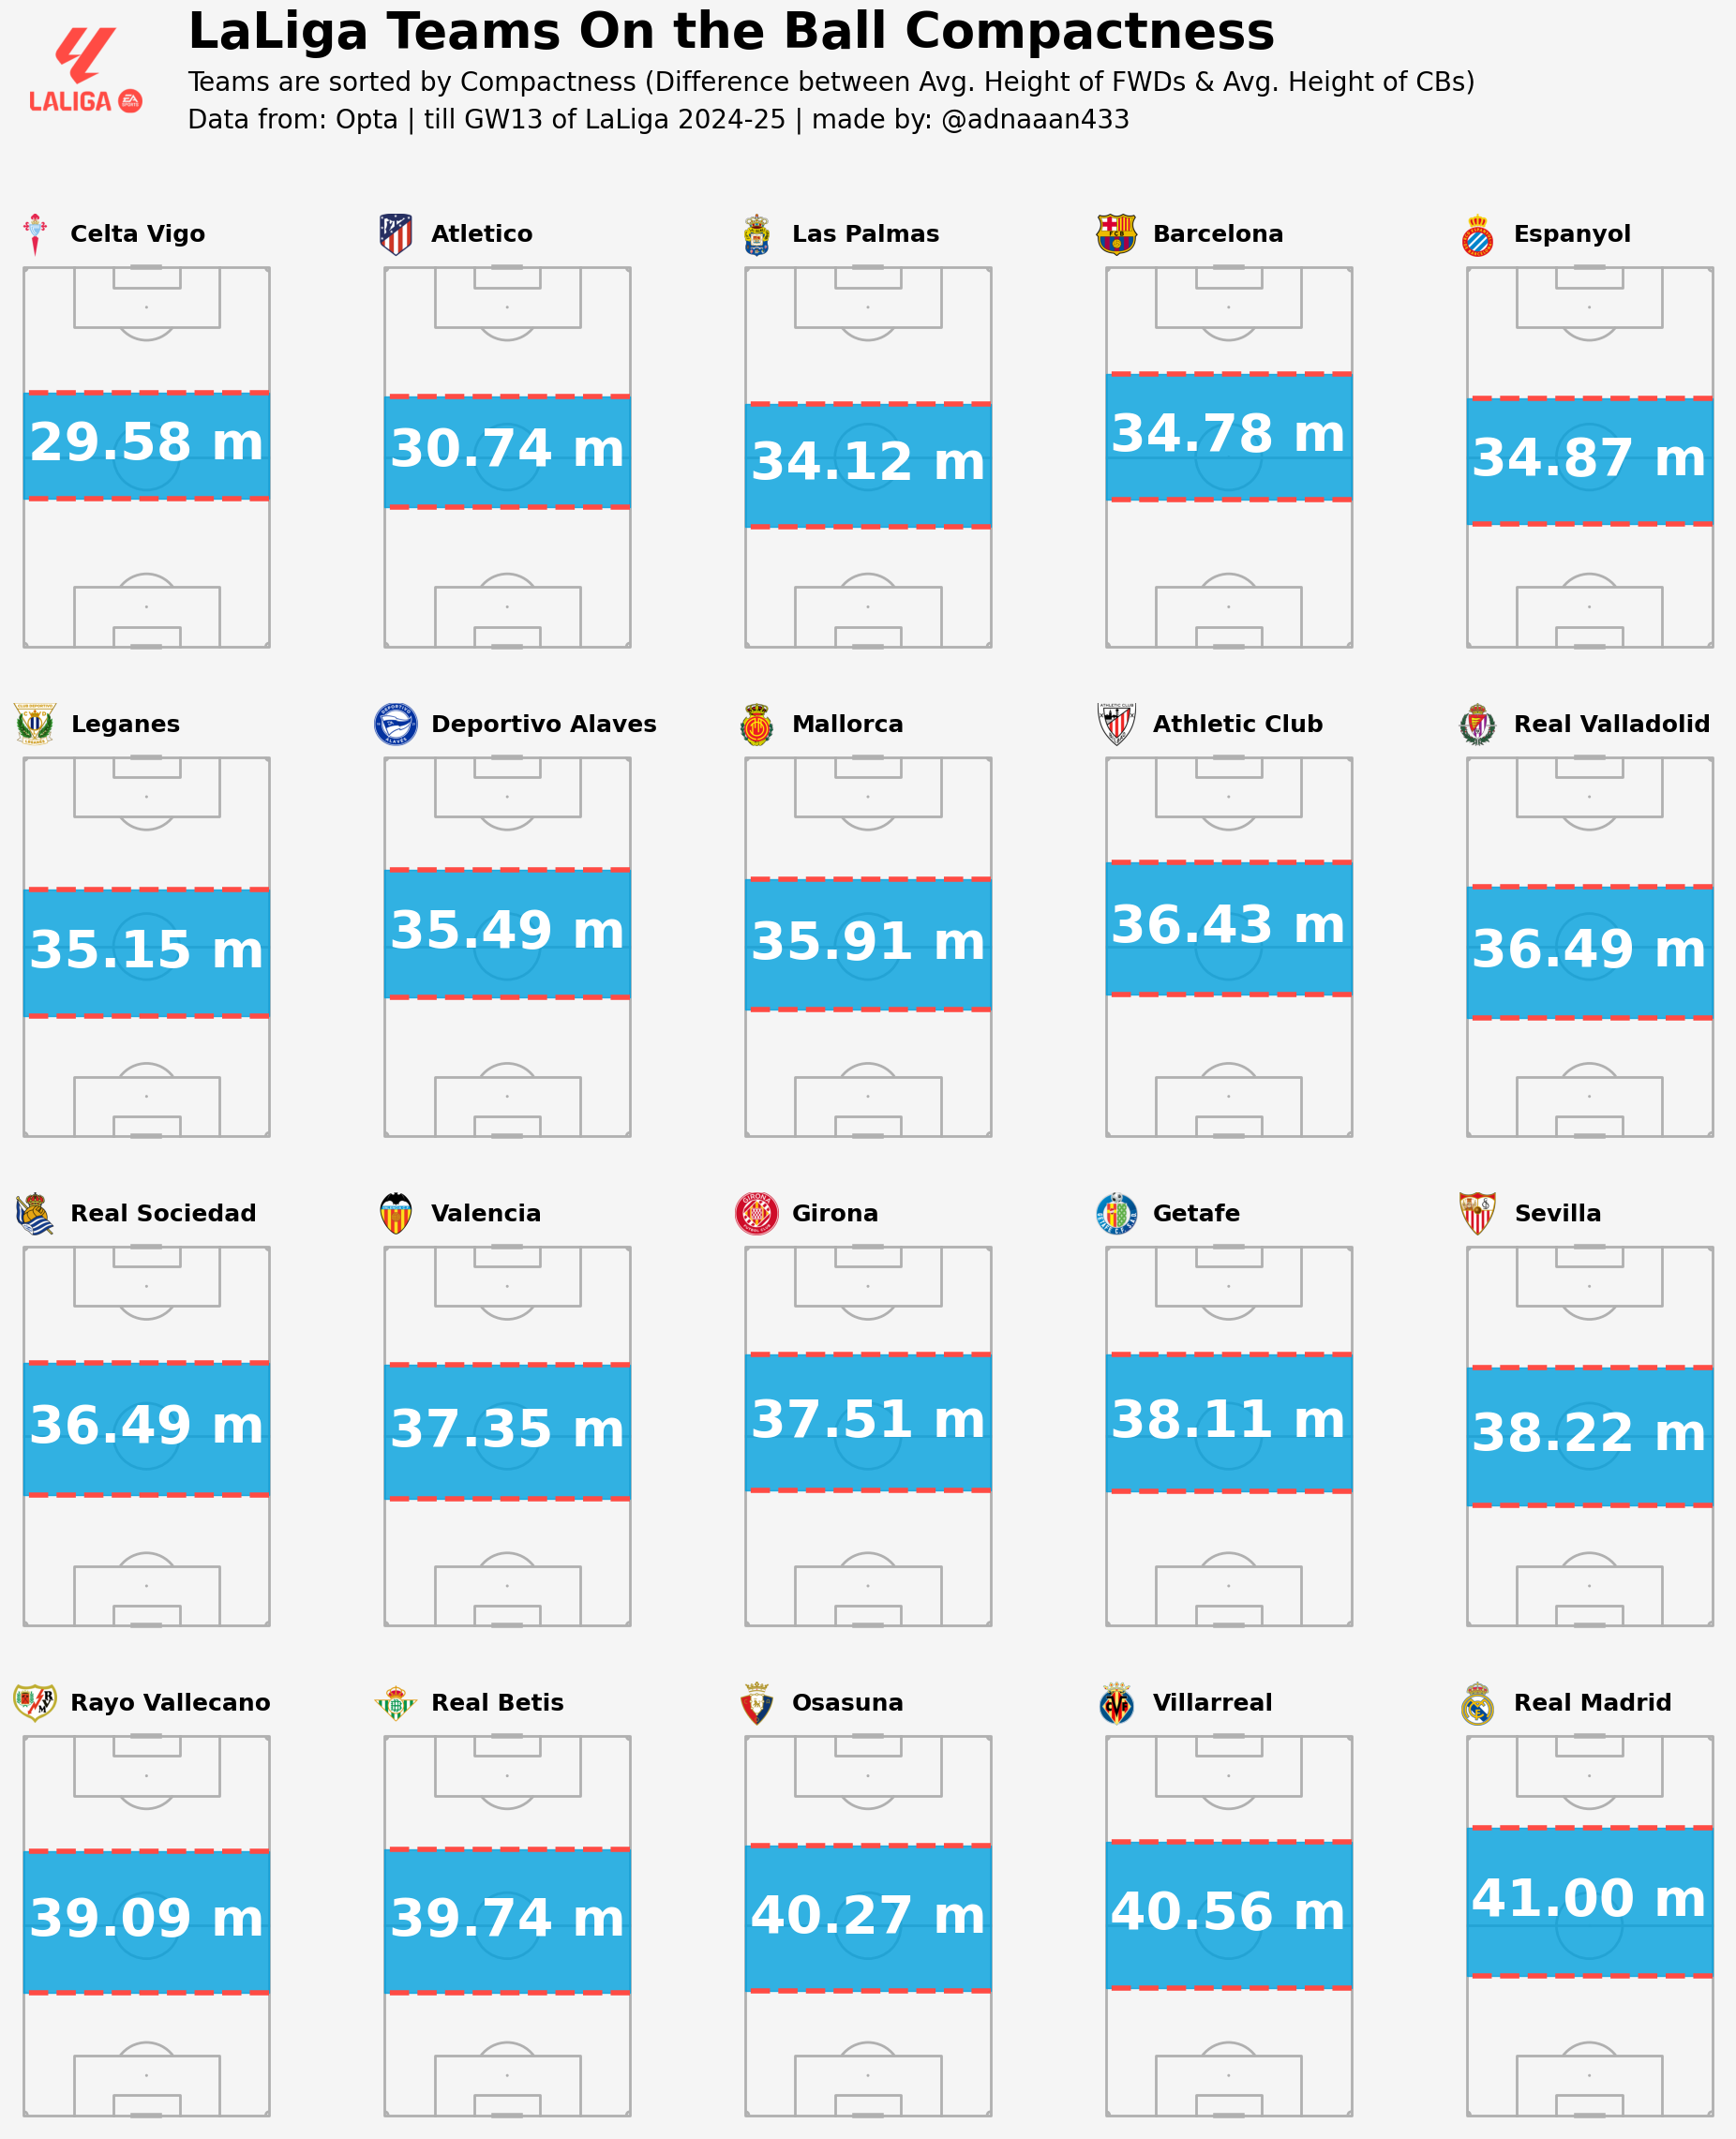

In [96]:
def calc_verticality(team_name):
    df_team = df[df['teamName']==team_name]
    match_ids = df_team['match_id'].unique()
    avg_h_data = {'match_id': match_ids, 'fwdh': [], 'defh': []}
    for mi in match_ids:
        df_m = df[df['match_id']==mi]
        # df_touch = df_m[(df_m['isTouch']==1) & (df_m['teamName']==team_name) & (df_m['isFirstEleven']==1) & (df_m['position']!='GK') &
        #                (~df_m['qualifiers'].str.contains('Freekick|Corner'))]
        df_touch = df_m[(df_m['type'].isin(['Pass', 'BallTouch', 'TakeOn', 'Dispossessed', 'Goal', 'SavedShot', 'MissedShots', 'ShotOnPost'])) & (df_m['teamName']==team_name) & (df_m['isFirstEleven']==1) & (df_m['position']!='GK') &
                       (~df_m['qualifiers'].str.contains('Freekick|Corner'))]
        df_touch = df_touch[['name', 'x', 'position']].reset_index(drop=True)
        avg_locs_df = df_touch.groupby('name').agg(avg_x=('x', 'median'), position=('position', 'first')).reset_index()
        avg_locs_df_top2 = avg_locs_df.sort_values(by='avg_x', ascending=False).head(2)
        fwdh = avg_locs_df_top2['avg_x'].mean()
        defh = avg_locs_df[avg_locs_df['position']=='DC']['avg_x'].median()
        avg_h_data['fwdh'].append(fwdh)
        avg_h_data['defh'].append(defh)
    
    avg_h_data = pd.DataFrame(avg_h_data)

    fx = avg_h_data['fwdh'].median()
    dx = avg_h_data['defh'].median()
    diff = fx-dx

    return diff

def plot_verticality(ax, team_name):
    pitch = VerticalPitch(pitch_type='uefa', pitch_color=bg_color, linewidth=2, corner_arcs=True)
    pitch.draw(ax=ax)
    df_team = df[df['teamName']==team_name]
    match_ids = df_team['match_id'].unique()
    avg_h_data = {'match_id': match_ids, 'fwdh': [], 'defh': []}
    for mi in match_ids:
        df_m = df[df['match_id']==mi]
        # df_touch = df_m[(df_m['isTouch']==1) & (df_m['teamName']==team_name) & (df_m['isFirstEleven']==1) & (df_m['position']!='GK') &
        #                (~df_m['qualifiers'].str.contains('Freekick|Corner'))]
        df_touch = df_m[(df_m['type'].isin(['Pass', 'BallTouch', 'TakeOn', 'Dispossessed', 'Goal', 'SavedShot', 'MissedShots', 'ShotOnPost'])) & (df_m['teamName']==team_name) & (df_m['isFirstEleven']==1) & (df_m['position']!='GK') &
                       (~df_m['qualifiers'].str.contains('Freekick|Corner'))]
        df_touch = df_touch[['name', 'x', 'position']].reset_index(drop=True)
        avg_locs_df = df_touch.groupby('name').agg(avg_x=('x', 'median'), position=('position', 'first')).reset_index()
        avg_locs_df_top2 = avg_locs_df.sort_values(by='avg_x', ascending=False).head(2)
        fwdh = avg_locs_df_top2['avg_x'].mean()
        defh = avg_locs_df[avg_locs_df['position']=='DC']['avg_x'].median()
        avg_h_data['fwdh'].append(fwdh)
        avg_h_data['defh'].append(defh)
    
    avg_h_data = pd.DataFrame(avg_h_data)

    fx = avg_h_data['fwdh'].median()
    dx = avg_h_data['defh'].median()
    diff = fx-dx

    ax.hlines(fx, xmin=0, xmax=68, color=col1, zorder=3, linewidth=4, linestyle='--')
    ax.hlines(dx, xmin=0, xmax=68, color=col1, zorder=3, linewidth=4, linestyle='--')
    fill_x = [0,68,68,0]
    fill_y = [dx,dx,fx,fx]
    ax.fill(fill_x, fill_y, color=col2, alpha=0.8)
    ax.text(34, ((fx+dx)/2), f'{diff:.2f} m', fontsize=40, color='w', fontweight='bold', ha='center', va='center')

    ax.text(55, 112, f'{team_name}', fontsize=18, fontweight='bold')
    IMAGE_URL = f'file:///D:/FData/club_teams_logo/all_league%20-%20Copy/{team_name}.html'
    image = Image.open(urlopen(IMAGE_URL))
    ax_image = pitch.inset_image(114, 65, image, height=12, ax=ax)



# List of team names
team_names = df.teamName.unique()

# Create a DataFrame with team names and their diff values
team_avg_x = pd.DataFrame({'teamName': team_names})
team_avg_x['diff'] = team_avg_x['teamName'].apply(calc_verticality)

# Sort the teams by diff value
team_avg_x_sorted = team_avg_x.sort_values(by='diff', ascending=True).dropna().reset_index(drop=True)

# Create the figure and axes for a 4x5 grid
fig, axes = plt.subplots(nrows=4, ncols=5, figsize=(24, 26), facecolor=bg_color)

# Flatten the axes array to easily loop through it
axes = axes.ravel()

# Loop through the sorted team names and corresponding axes
for i, row in enumerate(team_avg_x_sorted.itertuples()):
    team_name = row.teamName
    diff = row.diff
    plot_verticality(axes[i], team_name)
# plot_blank(axes[18])
# plot_blank(axes[19])

fig.text(0.21, 0.98, 'LaLiga Teams On the Ball Compactness', fontsize=38, fontweight='bold', ha='left', va='top')
fig.text(0.21, 0.955, "Teams are sorted by Compactness (Difference between Avg. Height of FWDs & Avg. Height of CBs)",
         fontsize=20, ha='left', va='top')
# fig_text(0.21, 0.94, "<Avg. Offensive Action Height of CenterBacks> | Overall Avg. Position of CneterBacks | <Avg. Defensive Action Height of CenterBacks>",
#          fontsize=17, ha='left', va='top', ax=fig, highlight_textprops=[{'color':col1}, {'color':col2}]_thin)
fig.text(0.21, 0.94, "Data from: Opta | till GW13 of LaLiga 2024-25 | made by: @adnaaan433",
         fontsize=20, ha='left', va='top')

image_url = 'file:///D:/FData/Leagues_logos/LaLiga%20.html'
image = urlopen(image_url)
image = Image.open(image)
ax_image = add_image(image, fig, left=0.14, bottom=0.93, width=0.05, height=0.05)

In [36]:
def calc_def_verticality(team_name):
    df_team = df[df['teamName']==team_name]
    match_ids = df_team['match_id'].unique()
    avg_h_data = {'match_id': match_ids, 'fwdh': [], 'defh': []}
    for mi in match_ids:
        df_m = df[df['match_id']==mi]
        df_touch = df_m[(df_m['type'].isin(['Tackle', 'BallRecovery', 'Interception', 'Challenge', 'BlockedPass', 'Foul'])) & 
                        (df_m['teamName']==team_name) & (df_m['isFirstEleven']==1) & (df_m['position']!='GK') &
                        (~df_m['qualifiers'].str.contains('Freekick|Corner'))]
        df_touch = df_touch[['name', 'x', 'position']].reset_index(drop=True)
        avg_locs_df = df_touch.groupby('name').agg(avg_x=('x', 'median'), position=('position', 'first')).reset_index()
        avg_locs_df_top2 = avg_locs_df.sort_values(by='avg_x', ascending=False).head(2)
        fwdh = avg_locs_df_top2['avg_x'].mean()
        defh = avg_locs_df[avg_locs_df['position']=='DC']['avg_x'].median()
        avg_h_data['fwdh'].append(fwdh)
        avg_h_data['defh'].append(defh)
    
    avg_h_data = pd.DataFrame(avg_h_data)

    fx = avg_h_data['fwdh'].median()
    dx = avg_h_data['defh'].median()
    diff = fx-dx

    return diff

def plot_def_verticality(ax, team_name):
    pitch = VerticalPitch(pitch_type='uefa', pitch_color=bg_color, linewidth=2, corner_arcs=True)
    pitch.draw(ax=ax)
    df_team = df[df['teamName']==team_name]
    match_ids = df_team['match_id'].unique()
    avg_h_data = {'match_id': match_ids, 'fwdh': [], 'defh': []}
    for mi in match_ids:
        df_m = df[df['match_id']==mi]
        df_touch = df_m[(df_m['type'].isin(['Tackle', 'BallRecovery', 'Interception', 'Challenge', 'BlockedPass', 'Foul'])) & 
                        (df_m['teamName']==team_name) & (df_m['isFirstEleven']==1) & (df_m['position']!='GK') &
                        (~df_m['qualifiers'].str.contains('Freekick|Corner'))]
        df_touch = df_touch[['name', 'x', 'position']].reset_index(drop=True)
        avg_locs_df = df_touch.groupby('name').agg(avg_x=('x', 'median'), position=('position', 'first')).reset_index()
        avg_locs_df_top2 = avg_locs_df.sort_values(by='avg_x', ascending=False).head(2)
        fwdh = avg_locs_df_top2['avg_x'].mean()
        defh = avg_locs_df[avg_locs_df['position']=='DC']['avg_x'].median()
        avg_h_data['fwdh'].append(fwdh)
        avg_h_data['defh'].append(defh)
    
    avg_h_data = pd.DataFrame(avg_h_data)

    fx = avg_h_data['fwdh'].median()
    dx = avg_h_data['defh'].median()
    diff = fx-dx

    ax.hlines(fx, xmin=0, xmax=68, color=col1, zorder=3, linewidth=4, linestyle='--')
    ax.hlines(dx, xmin=0, xmax=68, color=col1, zorder=3, linewidth=4, linestyle='--')
    fill_x = [0,68,68,0]
    fill_y = [dx,dx,fx,fx]
    ax.fill(fill_x, fill_y, color=col2, alpha=0.8)
    ax.text(34, ((fx+dx)/2), f'{diff:.2f} m', fontsize=40, color='w', fontweight='bold', ha='center', va='center')

    ax.text(55, 112, f'{team_name}', fontsize=18, fontweight='bold')
    IMAGE_URL = f'file:///D:/FData/club_teams_logo/all_league%20-%20Copy/{team_name}.html'
    image = Image.open(urlopen(IMAGE_URL))
    ax_image = pitch.inset_image(114, 65, image, height=12, ax=ax)

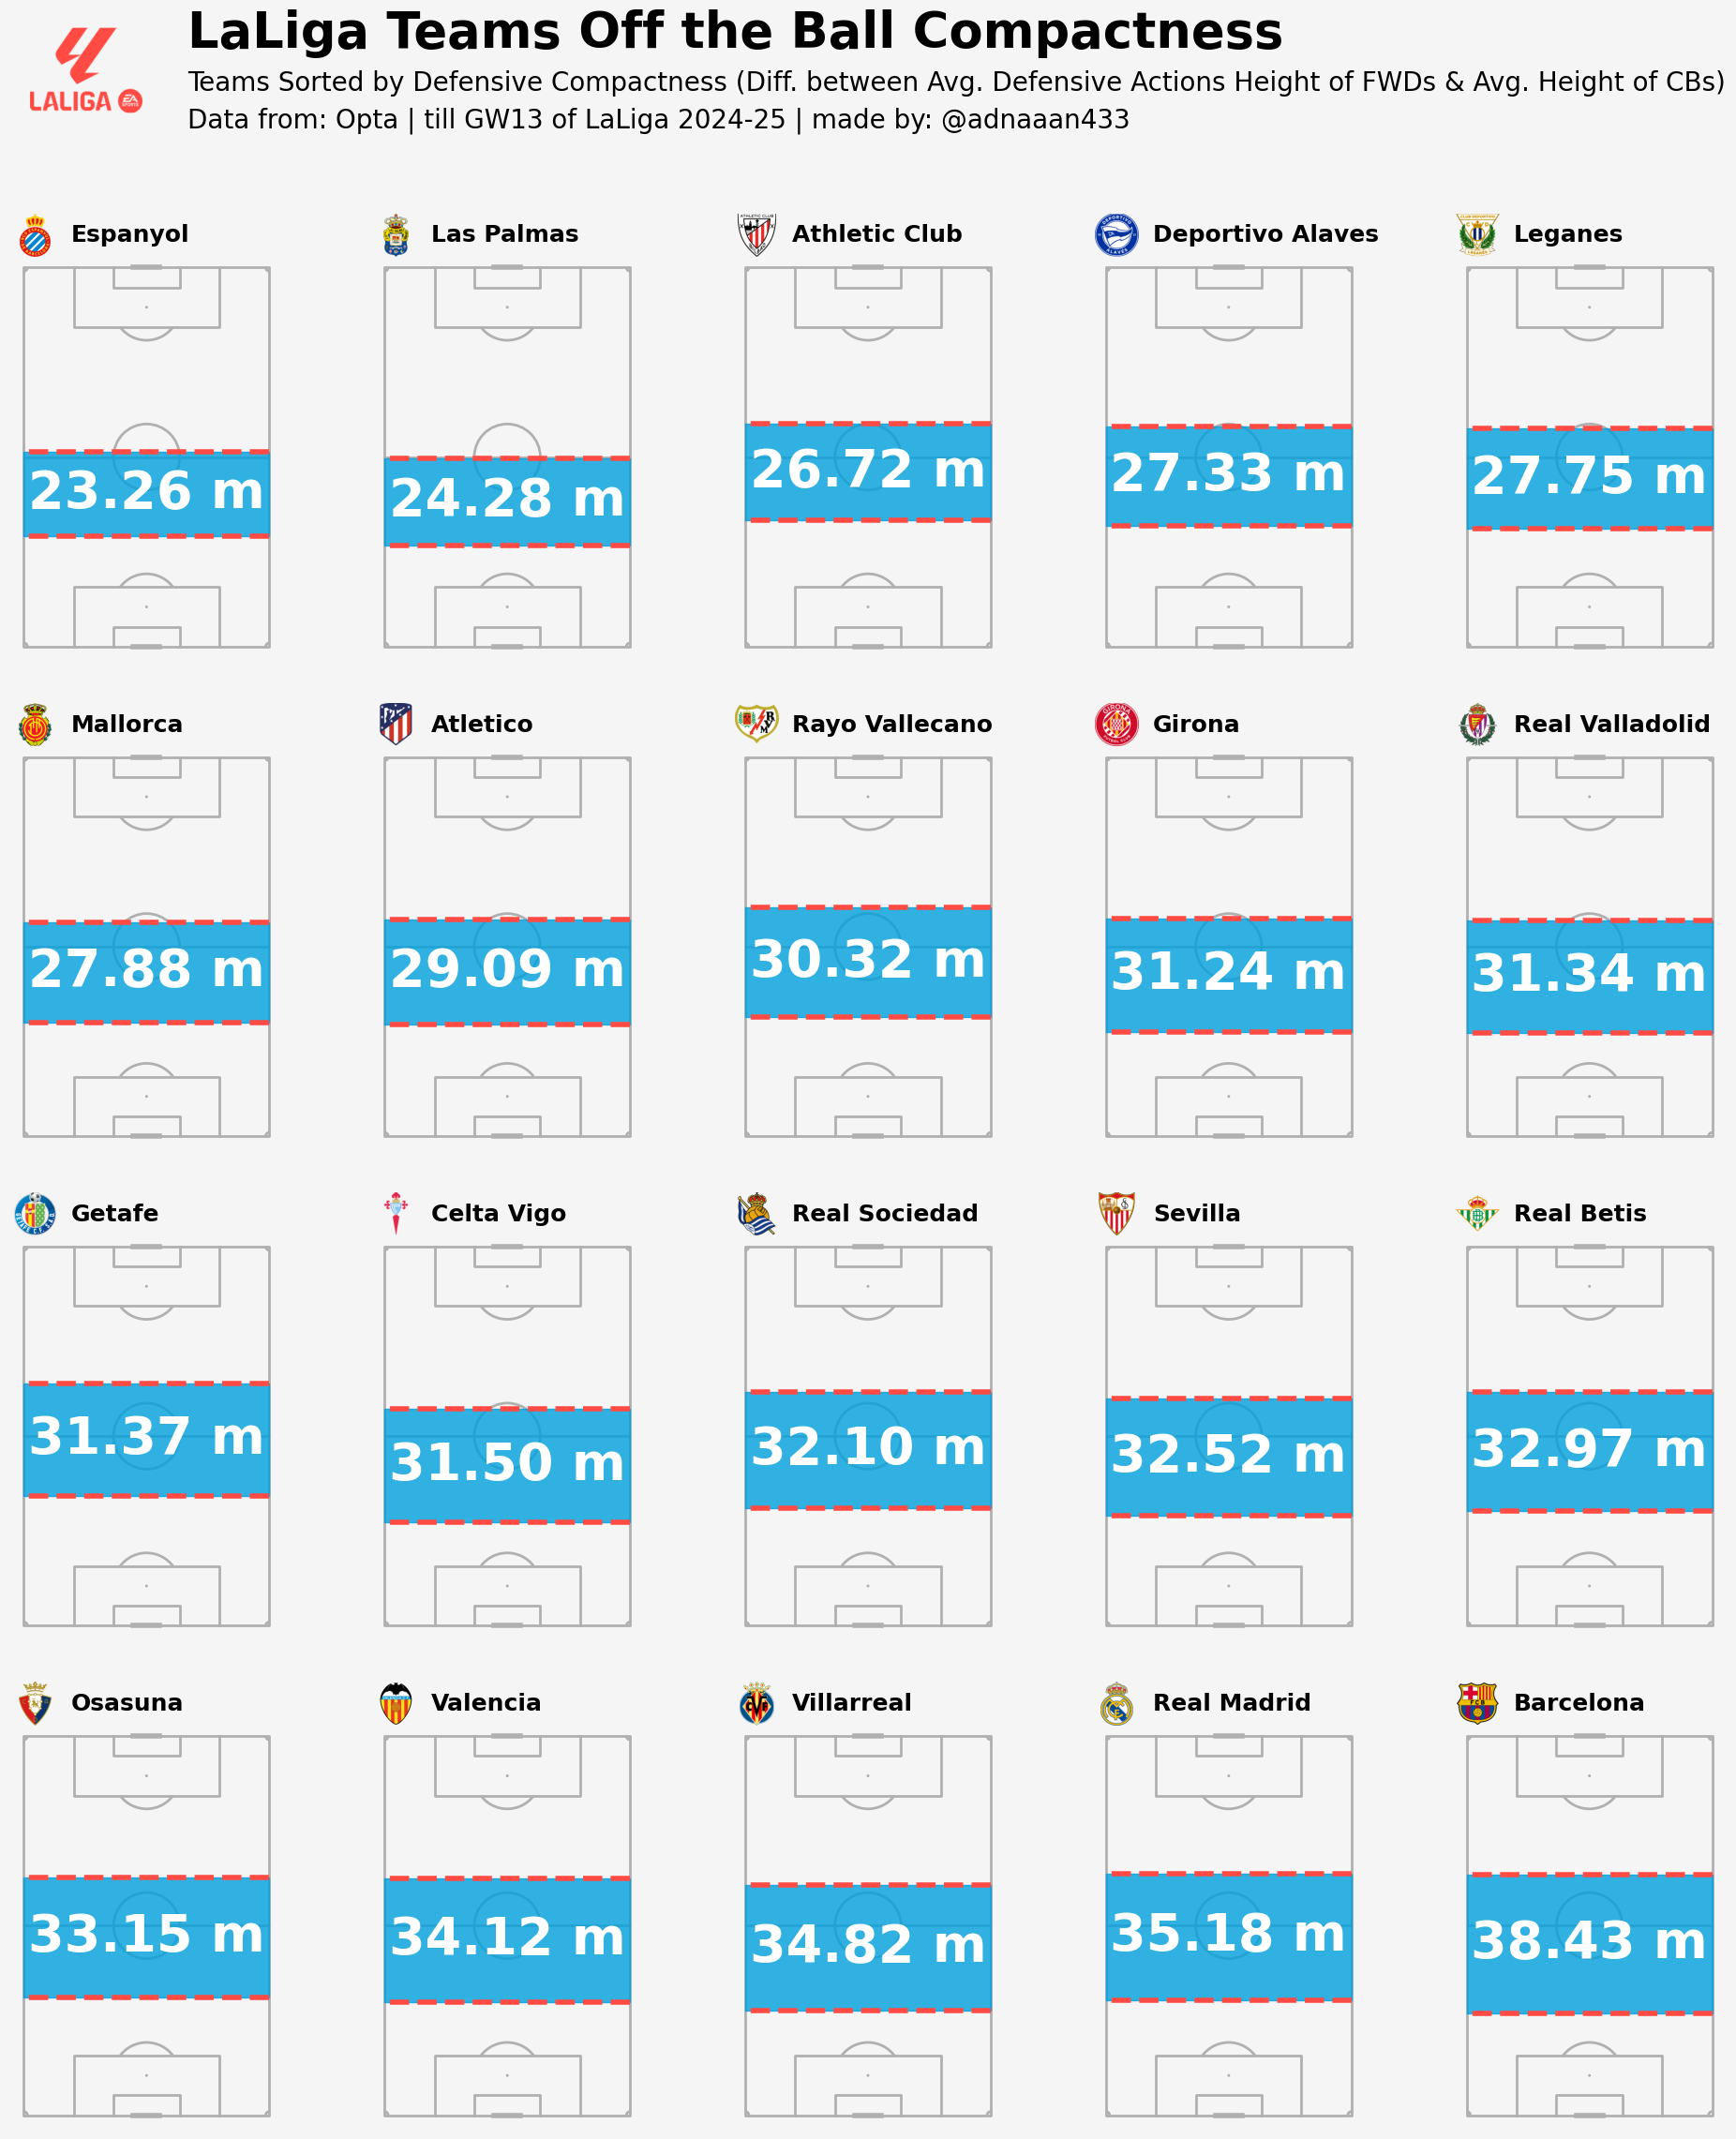

In [38]:
# List of team names
team_names = df.teamName.unique()

# Create a DataFrame with team names and their diff values
team_avg_x = pd.DataFrame({'teamName': team_names})
team_avg_x['diff'] = team_avg_x['teamName'].apply(calc_def_verticality)

# Sort the teams by diff value
team_avg_x_sorted = team_avg_x.sort_values(by='diff', ascending=True).dropna().reset_index(drop=True)

# Create the figure and axes for a 4x5 grid
fig, axes = plt.subplots(nrows=4, ncols=5, figsize=(24, 26), facecolor=bg_color)

# Flatten the axes array to easily loop through it
axes = axes.ravel()

# Loop through the sorted team names and corresponding axes
for i, row in enumerate(team_avg_x_sorted.itertuples()):
    team_name = row.teamName
    # diff = row.diff
    plot_def_verticality(axes[i], team_name)
# plot_blank(axes[18])
# plot_blank(axes[19])

fig.text(0.21, 0.98, 'LaLiga Teams Off the Ball Compactness', fontsize=38, fontweight='bold', ha='left', va='top')
fig.text(0.21, 0.955, "Teams Sorted by Defensive Compactness (Diff. between Avg. Defensive Actions Height of FWDs & Avg. Height of CBs)",
         fontsize=20, ha='left', va='top')
# fig_text(0.21, 0.94, "<Avg. Offensive Action Height of CenterBacks> | Overall Avg. Position of CneterBacks | <Avg. Defensive Action Height of CenterBacks>",
#          fontsize=17, ha='left', va='top', ax=fig, highlight_textprops=[{'color':col1}, {'color':col2}]_thin)
fig.text(0.21, 0.94, "Data from: Opta | till GW13 of LaLiga 2024-25 | made by: @adnaaan433",
         fontsize=20, ha='left', va='top')

image_url = 'file:///D:/FData/Leagues_logos/LaLiga%20.html'
image = urlopen(image_url)
image = Image.open(image)
ax_image = add_image(image, fig, left=0.14, bottom=0.93, width=0.05, height=0.05)

# EPL

In [39]:
df = pd.read_csv(r"D:\FData\EPL_2024_25\till_gw11.csv")

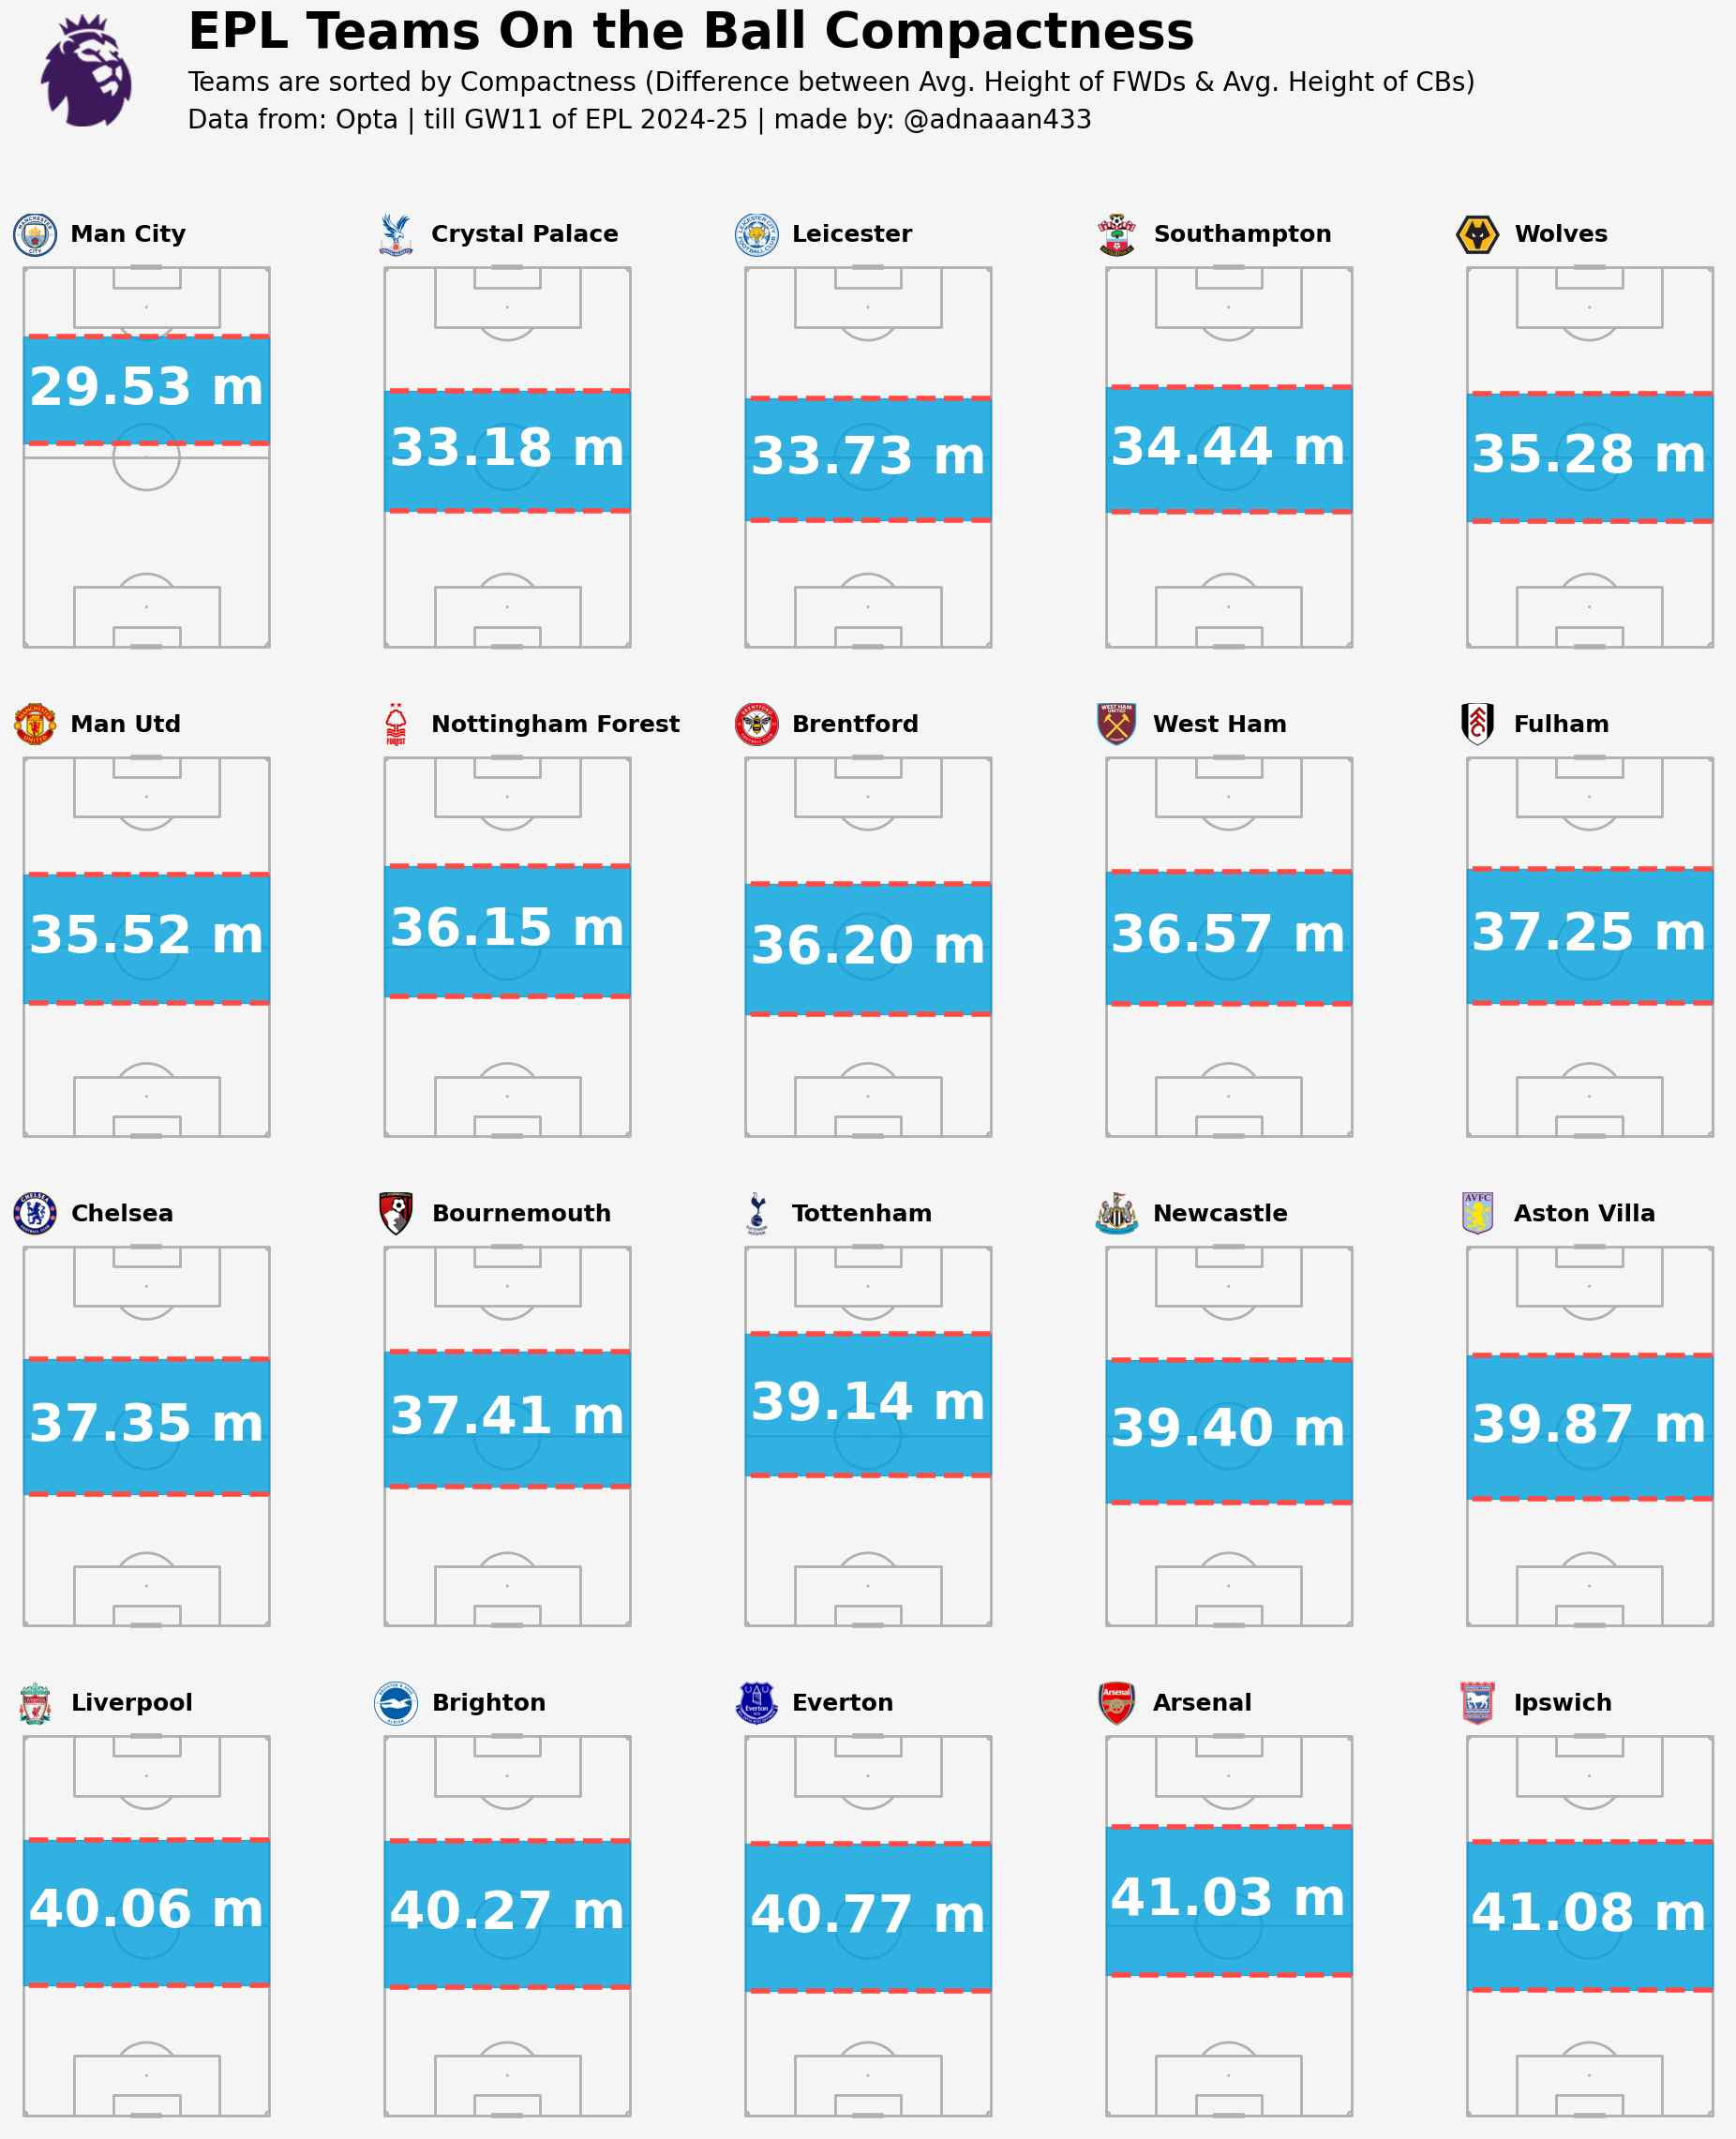

In [94]:
def calc_verticality(team_name):
    df_team = df[df['teamName']==team_name]
    match_ids = df_team['match_id'].unique()
    avg_h_data = {'match_id': match_ids, 'fwdh': [], 'defh': []}
    for mi in match_ids:
        df_m = df[df['match_id']==mi]
        # df_touch = df_m[(df_m['isTouch']==1) & (df_m['teamName']==team_name) & (df_m['isFirstEleven']==1) & (df_m['position']!='GK') &
        #                (~df_m['qualifiers'].str.contains('Freekick|Corner'))]
        df_touch = df_m[(df_m['type'].isin(['Pass', 'BallTouch', 'TakeOn', 'Dispossessed', 'Goal', 'SavedShot', 'MissedShots', 'ShotOnPost'])) & (df_m['teamName']==team_name) & (df_m['isFirstEleven']==1) & (df_m['position']!='GK') &
                       (~df_m['qualifiers'].str.contains('Freekick|Corner'))]
        df_touch = df_touch[['name', 'x', 'position']].reset_index(drop=True)
        avg_locs_df = df_touch.groupby('name').agg(avg_x=('x', 'median'), position=('position', 'first')).reset_index()
        avg_locs_df_top2 = avg_locs_df.sort_values(by='avg_x', ascending=False).head(2)
        fwdh = avg_locs_df_top2['avg_x'].mean()
        defh = avg_locs_df[avg_locs_df['position']=='DC']['avg_x'].median()
        avg_h_data['fwdh'].append(fwdh)
        avg_h_data['defh'].append(defh)
    
    avg_h_data = pd.DataFrame(avg_h_data)

    fx = avg_h_data['fwdh'].median()
    dx = avg_h_data['defh'].median()
    diff = fx-dx

    return diff

def plot_verticality(ax, team_name):
    pitch = VerticalPitch(pitch_type='uefa', pitch_color=bg_color, linewidth=2, corner_arcs=True)
    pitch.draw(ax=ax)
    df_team = df[df['teamName']==team_name]
    match_ids = df_team['match_id'].unique()
    avg_h_data = {'match_id': match_ids, 'fwdh': [], 'defh': []}
    for mi in match_ids:
        df_m = df[df['match_id']==mi]
        # df_touch = df_m[(df_m['isTouch']==1) & (df_m['teamName']==team_name) & (df_m['isFirstEleven']==1) & (df_m['position']!='GK') &
        #                (~df_m['qualifiers'].str.contains('Freekick|Corner'))]
        df_touch = df_m[(df_m['type'].isin(['Pass', 'BallTouch', 'TakeOn', 'Dispossessed', 'Goal', 'SavedShot', 'MissedShots', 'ShotOnPost'])) & (df_m['teamName']==team_name) & (df_m['isFirstEleven']==1) & (df_m['position']!='GK') &
                       (~df_m['qualifiers'].str.contains('Freekick|Corner'))]
        df_touch = df_touch[['name', 'x', 'position']].reset_index(drop=True)
        avg_locs_df = df_touch.groupby('name').agg(avg_x=('x', 'median'), position=('position', 'first')).reset_index()
        avg_locs_df_top2 = avg_locs_df.sort_values(by='avg_x', ascending=False).head(2)
        fwdh = avg_locs_df_top2['avg_x'].mean()
        defh = avg_locs_df[avg_locs_df['position']=='DC']['avg_x'].median()
        avg_h_data['fwdh'].append(fwdh)
        avg_h_data['defh'].append(defh)
    
    avg_h_data = pd.DataFrame(avg_h_data)

    fx = avg_h_data['fwdh'].median()
    dx = avg_h_data['defh'].median()
    diff = fx-dx

    ax.hlines(fx, xmin=0, xmax=68, color=col1, zorder=3, linewidth=4, linestyle='--')
    ax.hlines(dx, xmin=0, xmax=68, color=col1, zorder=3, linewidth=4, linestyle='--')
    fill_x = [0,68,68,0]
    fill_y = [dx,dx,fx,fx]
    ax.fill(fill_x, fill_y, color=col2, alpha=0.8)
    ax.text(34, ((fx+dx)/2), f'{diff:.2f} m', fontsize=40, color='w', fontweight='bold', ha='center', va='center')

    ax.text(55, 112, f'{team_name}', fontsize=18, fontweight='bold')
    IMAGE_URL = f'file:///D:/FData/club_teams_logo/all_league%20-%20Copy/{team_name}.html'
    image = Image.open(urlopen(IMAGE_URL))
    ax_image = pitch.inset_image(114, 65, image, height=12, ax=ax)



# List of team names
team_names = df.teamName.unique()

# Create a DataFrame with team names and their diff values
team_avg_x = pd.DataFrame({'teamName': team_names})
team_avg_x['diff'] = team_avg_x['teamName'].apply(calc_verticality)

# Sort the teams by diff value
team_avg_x_sorted = team_avg_x.sort_values(by='diff', ascending=True).dropna().reset_index(drop=True)

# Create the figure and axes for a 4x5 grid
fig, axes = plt.subplots(nrows=4, ncols=5, figsize=(24, 26), facecolor=bg_color)

# Flatten the axes array to easily loop through it
axes = axes.ravel()

# Loop through the sorted team names and corresponding axes
for i, row in enumerate(team_avg_x_sorted.itertuples()):
    team_name = row.teamName
    diff = row.diff
    plot_verticality(axes[i], team_name)

fig.text(0.21, 0.98, 'EPL Teams On the Ball Compactness', fontsize=38, fontweight='bold', ha='left', va='top')
fig.text(0.21, 0.955, "Teams are sorted by Compactness (Difference between Avg. Height of FWDs & Avg. Height of CBs)",
         fontsize=20, ha='left', va='top')
# fig_text(0.21, 0.94, "<Avg. Offensive Action Height of CenterBacks> | Overall Avg. Position of CneterBacks | <Avg. Defensive Action Height of CenterBacks>",
#          fontsize=17, ha='left', va='top', ax=fig, highlight_textprops=[{'color':col1}, {'color':col2}]_thin)
fig.text(0.21, 0.94, "Data from: Opta | till GW11 of EPL 2024-25 | made by: @adnaaan433",
         fontsize=20, ha='left', va='top')

image_url = 'file:///D:/FData/Leagues_logos/EPL_Logo.html'
image = urlopen(image_url)
image = Image.open(image)
ax_image = add_image(image, fig, left=0.14, bottom=0.93, width=0.05, height=0.05)

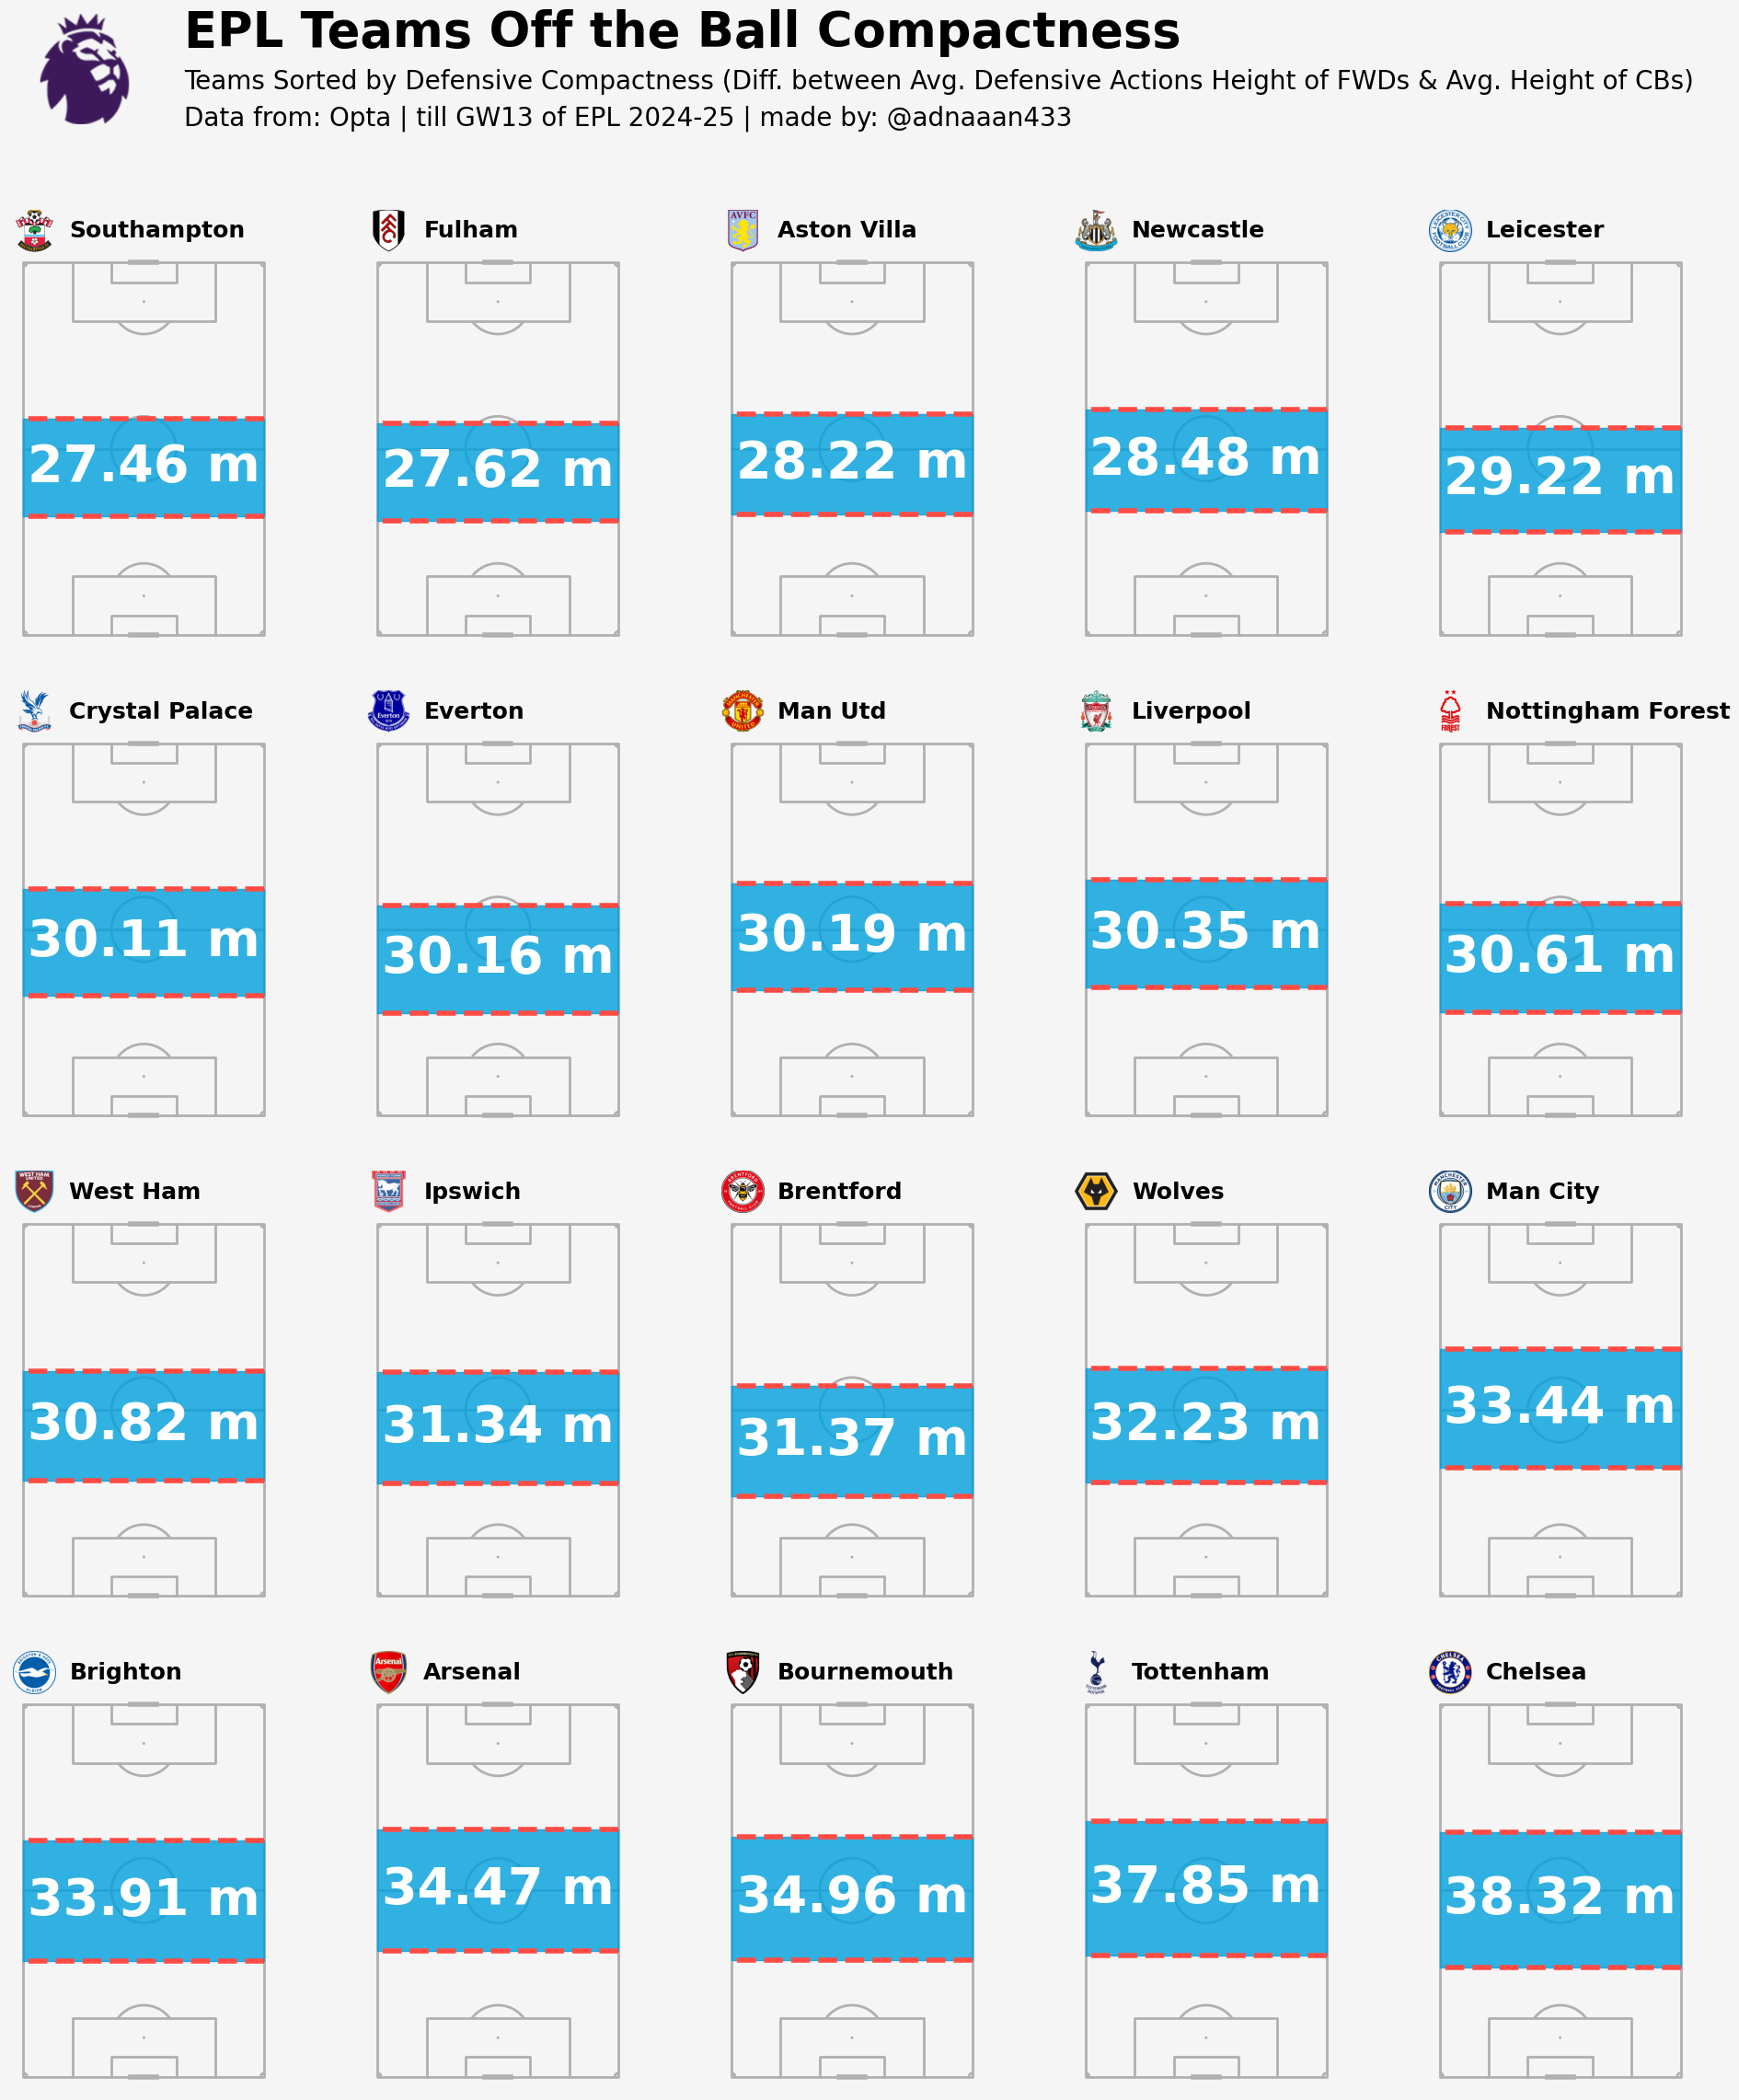

In [40]:
# List of team names
team_names = df.teamName.unique()

# Create a DataFrame with team names and their diff values
team_avg_x = pd.DataFrame({'teamName': team_names})
team_avg_x['diff'] = team_avg_x['teamName'].apply(calc_def_verticality)

# Sort the teams by diff value
team_avg_x_sorted = team_avg_x.sort_values(by='diff', ascending=True).dropna().reset_index(drop=True)

# Create the figure and axes for a 4x5 grid
fig, axes = plt.subplots(nrows=4, ncols=5, figsize=(24, 26), facecolor=bg_color)

# Flatten the axes array to easily loop through it
axes = axes.ravel()

# Loop through the sorted team names and corresponding axes
for i, row in enumerate(team_avg_x_sorted.itertuples()):
    team_name = row.teamName
    # diff = row.diff
    plot_def_verticality(axes[i], team_name)
# plot_blank(axes[18])
# plot_blank(axes[19])

fig.text(0.21, 0.98, 'EPL Teams Off the Ball Compactness', fontsize=38, fontweight='bold', ha='left', va='top')
fig.text(0.21, 0.955, "Teams Sorted by Defensive Compactness (Diff. between Avg. Defensive Actions Height of FWDs & Avg. Height of CBs)",
         fontsize=20, ha='left', va='top')
# fig_text(0.21, 0.94, "<Avg. Offensive Action Height of CenterBacks> | Overall Avg. Position of CneterBacks | <Avg. Defensive Action Height of CenterBacks>",
#          fontsize=17, ha='left', va='top', ax=fig, highlight_textprops=[{'color':col1}, {'color':col2}]_thin)
fig.text(0.21, 0.94, "Data from: Opta | till GW13 of EPL 2024-25 | made by: @adnaaan433",
         fontsize=20, ha='left', va='top')

image_url = 'file:///D:/FData/Leagues_logos/EPL_Logo.html'
image = urlopen(image_url)
image = Image.open(image)
ax_image = add_image(image, fig, left=0.14, bottom=0.93, width=0.05, height=0.05)

# Serie A

In [91]:
df = pd.read_csv(r"D:\FData\Serie_A_2024_25\till_gw12.csv")

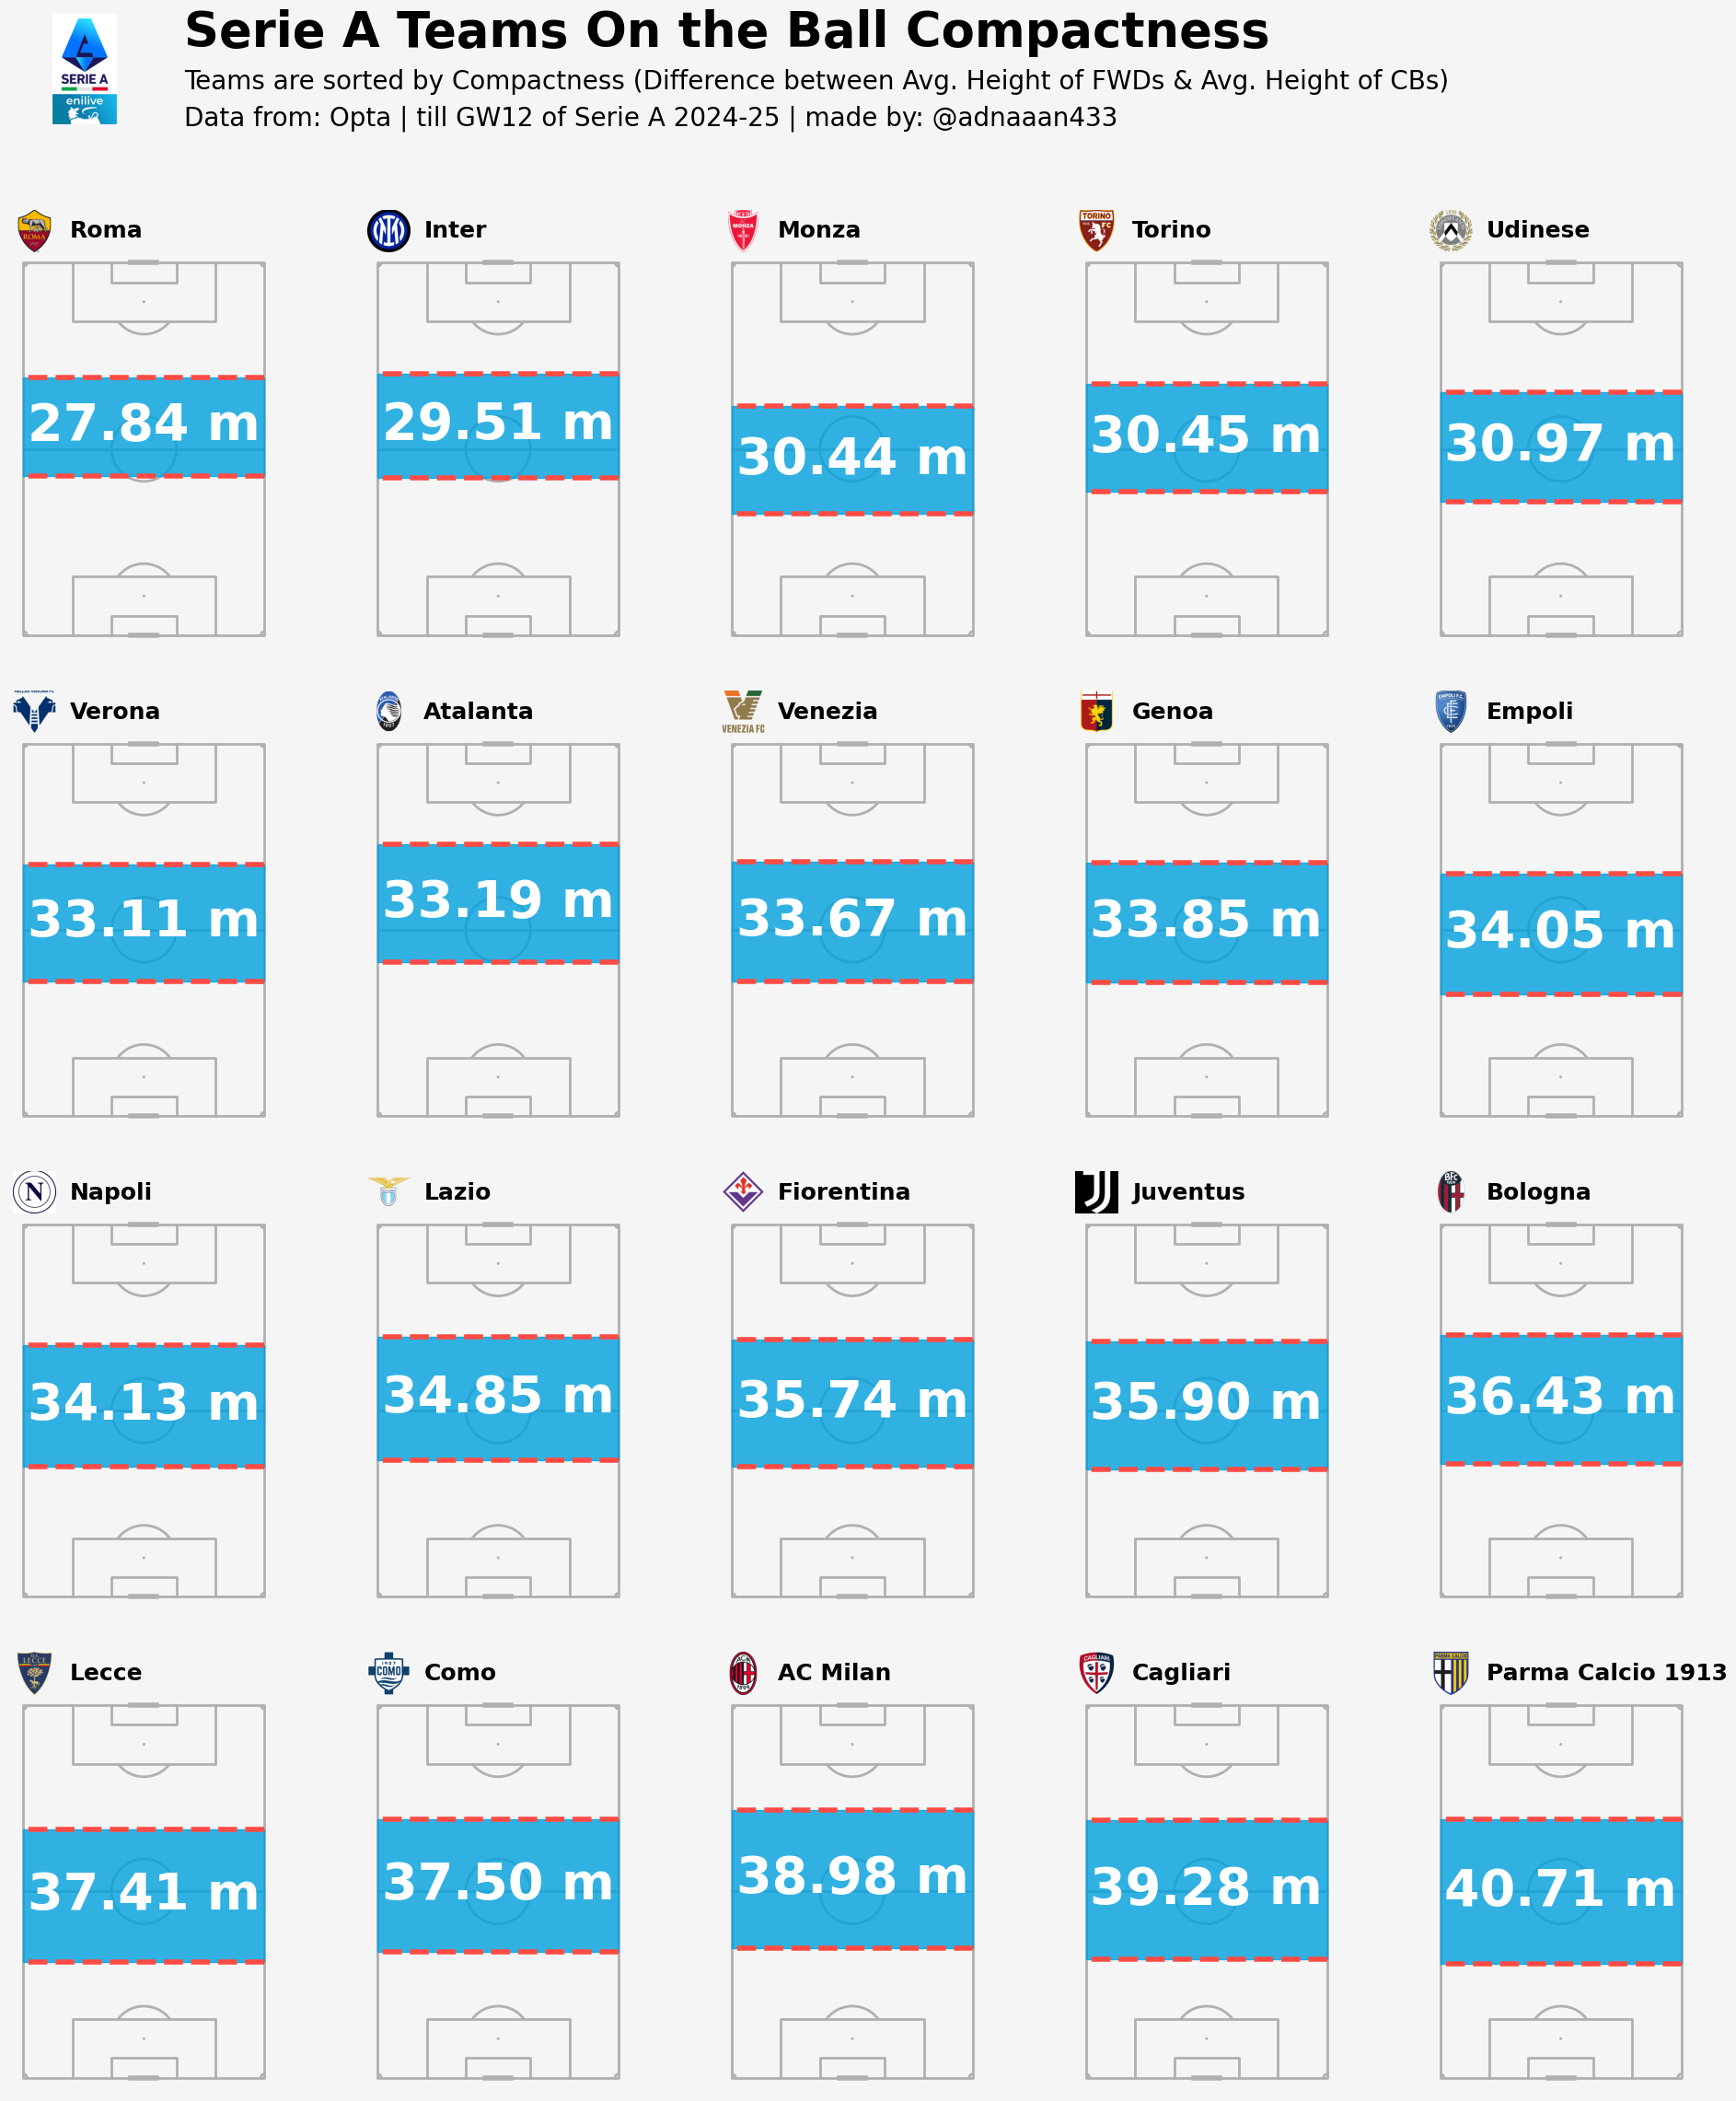

In [92]:
def calc_verticality(team_name):
    df_team = df[df['teamName']==team_name]
    match_ids = df_team['match_id'].unique()
    avg_h_data = {'match_id': match_ids, 'fwdh': [], 'defh': []}
    for mi in match_ids:
        df_m = df[df['match_id']==mi]
        # df_touch = df_m[(df_m['isTouch']==1) & (df_m['teamName']==team_name) & (df_m['isFirstEleven']==1) & (df_m['position']!='GK') &
        #                (~df_m['qualifiers'].str.contains('Freekick|Corner'))]
        df_touch = df_m[(df_m['type'].isin(['Pass', 'BallTouch', 'TakeOn', 'Dispossessed', 'Goal', 'SavedShot', 'MissedShots', 'ShotOnPost'])) & (df_m['teamName']==team_name) & (df_m['isFirstEleven']==1) & (df_m['position']!='GK') &
                       (~df_m['qualifiers'].str.contains('Freekick|Corner'))]
        df_touch = df_touch[['name', 'x', 'position']].reset_index(drop=True)
        avg_locs_df = df_touch.groupby('name').agg(avg_x=('x', 'median'), position=('position', 'first')).reset_index()
        avg_locs_df_top2 = avg_locs_df.sort_values(by='avg_x', ascending=False).head(2)
        fwdh = avg_locs_df_top2['avg_x'].mean()
        defh = avg_locs_df[avg_locs_df['position']=='DC']['avg_x'].median()
        avg_h_data['fwdh'].append(fwdh)
        avg_h_data['defh'].append(defh)
    
    avg_h_data = pd.DataFrame(avg_h_data)

    fx = avg_h_data['fwdh'].median()
    dx = avg_h_data['defh'].median()
    diff = fx-dx

    return diff

def plot_verticality(ax, team_name):
    pitch = VerticalPitch(pitch_type='uefa', pitch_color=bg_color, linewidth=2, corner_arcs=True)
    pitch.draw(ax=ax)
    df_team = df[df['teamName']==team_name]
    match_ids = df_team['match_id'].unique()
    avg_h_data = {'match_id': match_ids, 'fwdh': [], 'defh': []}
    for mi in match_ids:
        df_m = df[df['match_id']==mi]
        # df_touch = df_m[(df_m['isTouch']==1) & (df_m['teamName']==team_name) & (df_m['isFirstEleven']==1) & (df_m['position']!='GK') &
        #                (~df_m['qualifiers'].str.contains('Freekick|Corner'))]
        df_touch = df_m[(df_m['type'].isin(['Pass', 'BallTouch', 'TakeOn', 'Dispossessed', 'Goal', 'SavedShot', 'MissedShots', 'ShotOnPost'])) & (df_m['teamName']==team_name) & (df_m['isFirstEleven']==1) & (df_m['position']!='GK') &
                       (~df_m['qualifiers'].str.contains('Freekick|Corner'))]
        df_touch = df_touch[['name', 'x', 'position']].reset_index(drop=True)
        avg_locs_df = df_touch.groupby('name').agg(avg_x=('x', 'median'), position=('position', 'first')).reset_index()
        avg_locs_df_top2 = avg_locs_df.sort_values(by='avg_x', ascending=False).head(2)
        fwdh = avg_locs_df_top2['avg_x'].mean()
        defh = avg_locs_df[avg_locs_df['position']=='DC']['avg_x'].median()
        avg_h_data['fwdh'].append(fwdh)
        avg_h_data['defh'].append(defh)
    
    avg_h_data = pd.DataFrame(avg_h_data)

    fx = avg_h_data['fwdh'].median()
    dx = avg_h_data['defh'].median()
    diff = fx-dx

    ax.hlines(fx, xmin=0, xmax=68, color=col1, zorder=3, linewidth=4, linestyle='--')
    ax.hlines(dx, xmin=0, xmax=68, color=col1, zorder=3, linewidth=4, linestyle='--')
    fill_x = [0,68,68,0]
    fill_y = [dx,dx,fx,fx]
    ax.fill(fill_x, fill_y, color=col2, alpha=0.8)
    ax.text(34, ((fx+dx)/2), f'{diff:.2f} m', fontsize=40, color='w', fontweight='bold', ha='center', va='center')

    ax.text(55, 112, f'{team_name}', fontsize=18, fontweight='bold')
    IMAGE_URL = f'file:///D:/FData/club_teams_logo/all_league%20-%20Copy/{team_name}.html'
    image = Image.open(urlopen(IMAGE_URL))
    ax_image = pitch.inset_image(114, 65, image, height=12, ax=ax)

# List of team names
team_names = df.teamName.unique()

# Create a DataFrame with team names and their diff values
team_avg_x = pd.DataFrame({'teamName': team_names})
team_avg_x['diff'] = team_avg_x['teamName'].apply(calc_verticality)

# Sort the teams by diff value
team_avg_x_sorted = team_avg_x.sort_values(by='diff', ascending=True).dropna().reset_index(drop=True)

# Create the figure and axes for a 4x5 grid
fig, axes = plt.subplots(nrows=4, ncols=5, figsize=(24, 26), facecolor=bg_color)

# Flatten the axes array to easily loop through it
axes = axes.ravel()

# Loop through the sorted team names and corresponding axes
for i, row in enumerate(team_avg_x_sorted.itertuples()):
    team_name = row.teamName
    diff = row.diff
    plot_verticality(axes[i], team_name)
# plot_blank(axes[18])
# plot_blank(axes[19])

fig.text(0.21, 0.98, 'Serie A Teams On the Ball Compactness', fontsize=38, fontweight='bold', ha='left', va='top')
fig.text(0.21, 0.955, "Teams are sorted by Compactness (Difference between Avg. Height of FWDs & Avg. Height of CBs)",
         fontsize=20, ha='left', va='top')
# fig_text(0.21, 0.94, "<Avg. Offensive Action Height of CenterBacks> | Overall Avg. Position of CneterBacks | <Avg. Defensive Action Height of CenterBacks>",
#          fontsize=17, ha='left', va='top', ax=fig, highlight_textprops=[{'color':col1}, {'color':col2}]_thin)
fig.text(0.21, 0.94, "Data from: Opta | till GW12 of Serie A 2024-25 | made by: @adnaaan433",
         fontsize=20, ha='left', va='top')

image_url = 'file:///D:/FData/Leagues_logos/Serie_A_logo.html'
image = urlopen(image_url)
image = Image.open(image)
ax_image = add_image(image, fig, left=0.14, bottom=0.93, width=0.05, height=0.05)

# Ligue 1

In [88]:
df = pd.read_csv(r"D:\FData\Ligue1_2024_25\ligue1_24_25_event_data_till_gw11.csv")

In [89]:
def plot_blank(ax):
    pitch = VerticalPitch(pitch_type='uefa', pitch_color=bg_color, line_color=bg_color, linewidth=2, corner_arcs=True)
    pitch.draw(ax=ax)

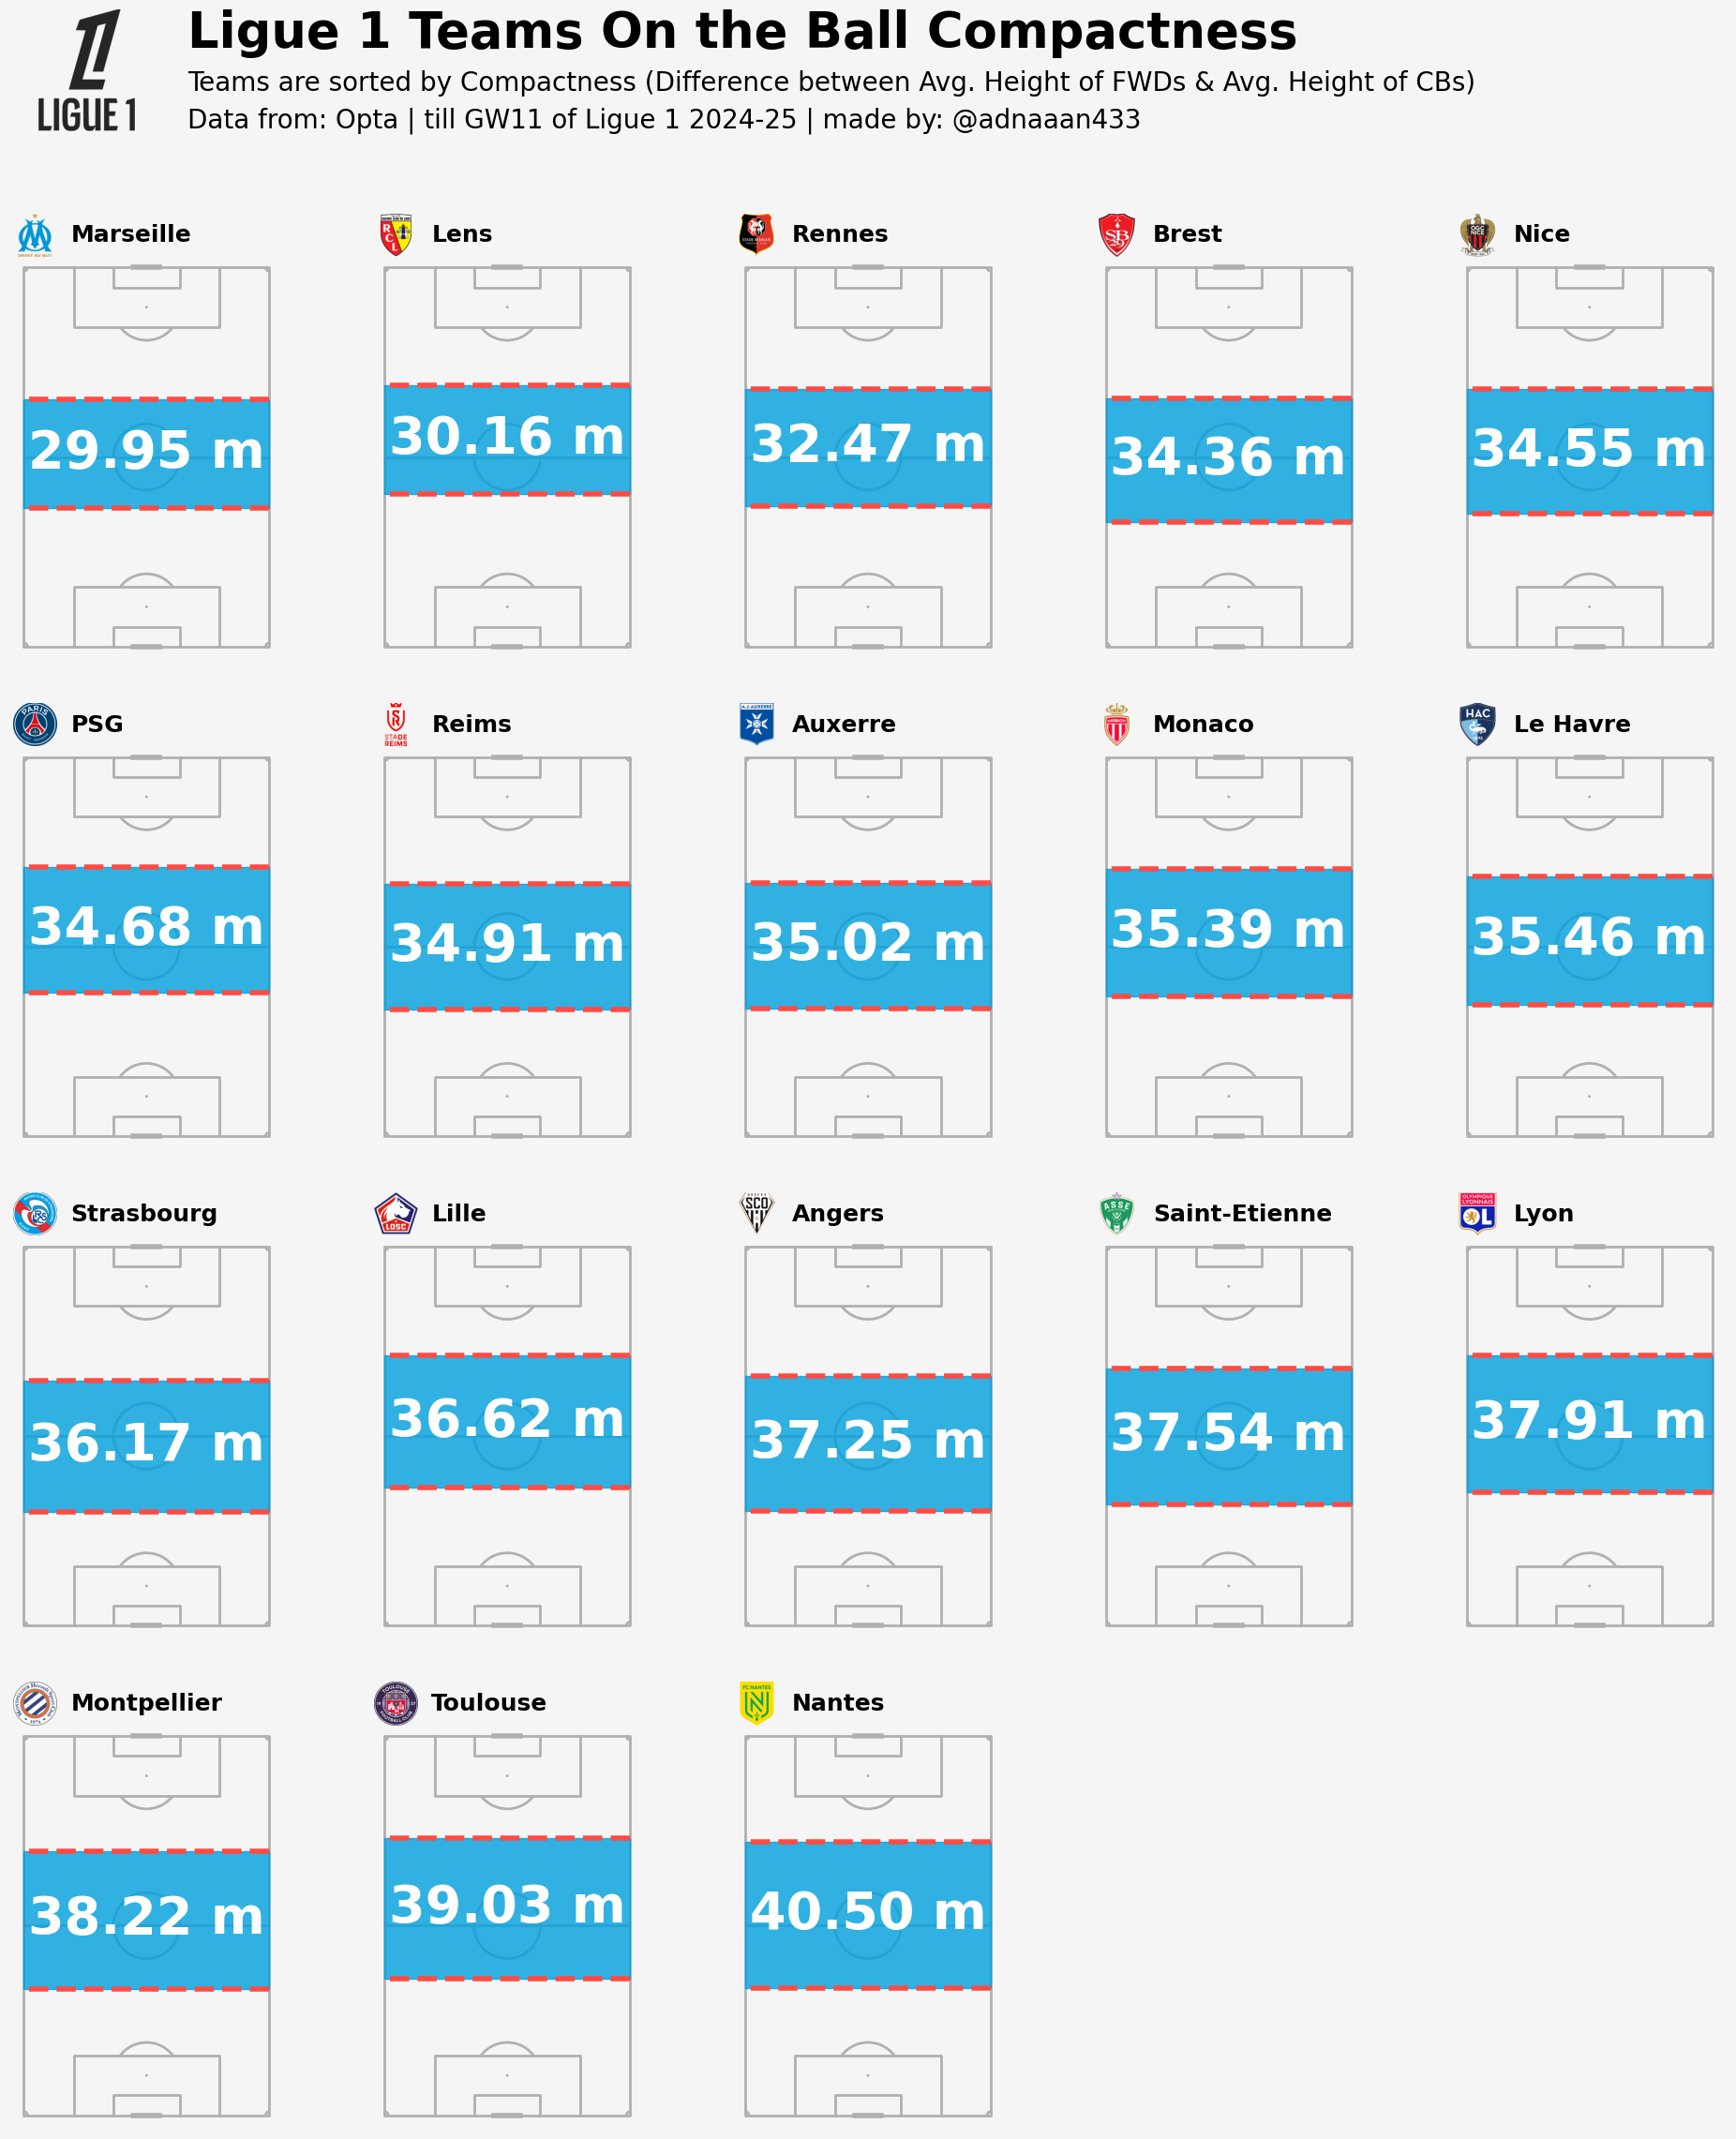

In [90]:
def calc_verticality(team_name):
    df_team = df[df['teamName']==team_name]
    match_ids = df_team['matchId'].unique()
    avg_h_data = {'matchId': match_ids, 'fwdh': [], 'defh': []}
    for mi in match_ids:
        df_m = df[df['matchId']==mi]
        # df_touch = df_m[(df_m['isTouch']==1) & (df_m['teamName']==team_name) & (df_m['isFirstEleven']==1) & (df_m['position']!='GK') &
        #                (~df_m['qualifiers'].str.contains('Freekick|Corner'))]
        df_touch = df_m[(df_m['type'].isin(['Pass', 'BallTouch', 'TakeOn', 'Dispossessed', 'Goal', 'SavedShot', 'MissedShots', 'ShotOnPost'])) & (df_m['teamName']==team_name) & (df_m['isFirstEleven']==1) & (df_m['position']!='GK') &
                       (~df_m['qualifiers'].str.contains('Freekick|Corner'))]
        df_touch = df_touch[['playerName', 'x', 'position']].reset_index(drop=True)
        avg_locs_df = df_touch.groupby('playerName').agg(avg_x=('x', 'median'), position=('position', 'first')).reset_index()
        avg_locs_df_top2 = avg_locs_df.sort_values(by='avg_x', ascending=False).head(2)
        fwdh = avg_locs_df_top2['avg_x'].mean()
        defh = avg_locs_df[avg_locs_df['position']=='DC']['avg_x'].median()
        avg_h_data['fwdh'].append(fwdh)
        avg_h_data['defh'].append(defh)
    
    avg_h_data = pd.DataFrame(avg_h_data)

    fx = avg_h_data['fwdh'].median()
    dx = avg_h_data['defh'].median()
    diff = fx-dx

    return diff

def plot_verticality(ax, team_name):
    pitch = VerticalPitch(pitch_type='uefa', pitch_color=bg_color, linewidth=2, corner_arcs=True)
    pitch.draw(ax=ax)
    df_team = df[df['teamName']==team_name]
    match_ids = df_team['matchId'].unique()
    avg_h_data = {'matchId': match_ids, 'fwdh': [], 'defh': []}
    for mi in match_ids:
        df_m = df[df['matchId']==mi]
        # df_touch = df_m[(df_m['isTouch']==1) & (df_m['teamName']==team_name) & (df_m['isFirstEleven']==1) & (df_m['position']!='GK') &
        #                (~df_m['qualifiers'].str.contains('Freekick|Corner'))]
        df_touch = df_m[(df_m['type'].isin(['Pass', 'BallTouch', 'TakeOn', 'Dispossessed', 'Goal', 'SavedShot', 'MissedShots', 'ShotOnPost'])) & (df_m['teamName']==team_name) & (df_m['isFirstEleven']==1) & (df_m['position']!='GK') &
                       (~df_m['qualifiers'].str.contains('Freekick|Corner'))]
        df_touch = df_touch[['playerName', 'x', 'position']].reset_index(drop=True)
        avg_locs_df = df_touch.groupby('playerName').agg(avg_x=('x', 'median'), position=('position', 'first')).reset_index()
        avg_locs_df_top2 = avg_locs_df.sort_values(by='avg_x', ascending=False).head(2)
        fwdh = avg_locs_df_top2['avg_x'].mean()
        defh = avg_locs_df[avg_locs_df['position']=='DC']['avg_x'].median()
        avg_h_data['fwdh'].append(fwdh)
        avg_h_data['defh'].append(defh)
    
    avg_h_data = pd.DataFrame(avg_h_data)

    fx = avg_h_data['fwdh'].median()
    dx = avg_h_data['defh'].median()
    diff = fx-dx

    ax.hlines(fx, xmin=0, xmax=68, color=col1, zorder=3, linewidth=4, linestyle='--')
    ax.hlines(dx, xmin=0, xmax=68, color=col1, zorder=3, linewidth=4, linestyle='--')
    fill_x = [0,68,68,0]
    fill_y = [dx,dx,fx,fx]
    ax.fill(fill_x, fill_y, color=col2, alpha=0.8)
    ax.text(34, ((fx+dx)/2), f'{diff:.2f} m', fontsize=40, color='w', fontweight='bold', ha='center', va='center')

    ax.text(55, 112, f'{team_name}', fontsize=18, fontweight='bold')
    IMAGE_URL = f'file:///D:/FData/club_teams_logo/all_league%20-%20Copy/{team_name}.html'
    image = Image.open(urlopen(IMAGE_URL))
    ax_image = pitch.inset_image(114, 65, image, height=12, ax=ax)

# List of team names
team_names = df.teamName.unique()

# Create a DataFrame with team names and their diff values
team_avg_x = pd.DataFrame({'teamName': team_names})
team_avg_x['diff'] = team_avg_x['teamName'].apply(calc_verticality)

# Sort the teams by diff value
team_avg_x_sorted = team_avg_x.sort_values(by='diff', ascending=True).dropna().reset_index(drop=True)

# Create the figure and axes for a 4x5 grid
fig, axes = plt.subplots(nrows=4, ncols=5, figsize=(24, 26), facecolor=bg_color)

# Flatten the axes array to easily loop through it
axes = axes.ravel()

# Loop through the sorted team names and corresponding axes
for i, row in enumerate(team_avg_x_sorted.itertuples()):
    team_name = row.teamName
    diff = row.diff
    plot_verticality(axes[i], team_name)
plot_blank(axes[18])
plot_blank(axes[19])

fig.text(0.21, 0.98, 'Ligue 1 Teams On the Ball Compactness', fontsize=38, fontweight='bold', ha='left', va='top')
fig.text(0.21, 0.955, "Teams are sorted by Compactness (Difference between Avg. Height of FWDs & Avg. Height of CBs)",
         fontsize=20, ha='left', va='top')
# fig_text(0.21, 0.94, "<Avg. Offensive Action Height of CenterBacks> | Overall Avg. Position of CneterBacks | <Avg. Defensive Action Height of CenterBacks>",
#          fontsize=17, ha='left', va='top', ax=fig, highlight_textprops=[{'color':col1}, {'color':col2}]_thin)
fig.text(0.21, 0.94, "Data from: Opta | till GW11 of Ligue 1 2024-25 | made by: @adnaaan433",
         fontsize=20, ha='left', va='top')

image_url = 'file:///D:/FData/Leagues_logos/Ligue_1_logo.html'
image = urlopen(image_url)
image = Image.open(image)
ax_image = add_image(image, fig, left=0.14, bottom=0.93, width=0.05, height=0.05)

# BundesLiga

In [79]:
df = pd.read_csv(r"D:\FData\Bundesliga_2024_25\bundesliga_24_25_event_data_till_gw10.csv")

In [80]:
def plot_blank(ax):
    pitch = VerticalPitch(pitch_type='uefa', pitch_color=bg_color, line_color=bg_color, linewidth=2, corner_arcs=True)
    pitch.draw(ax=ax)

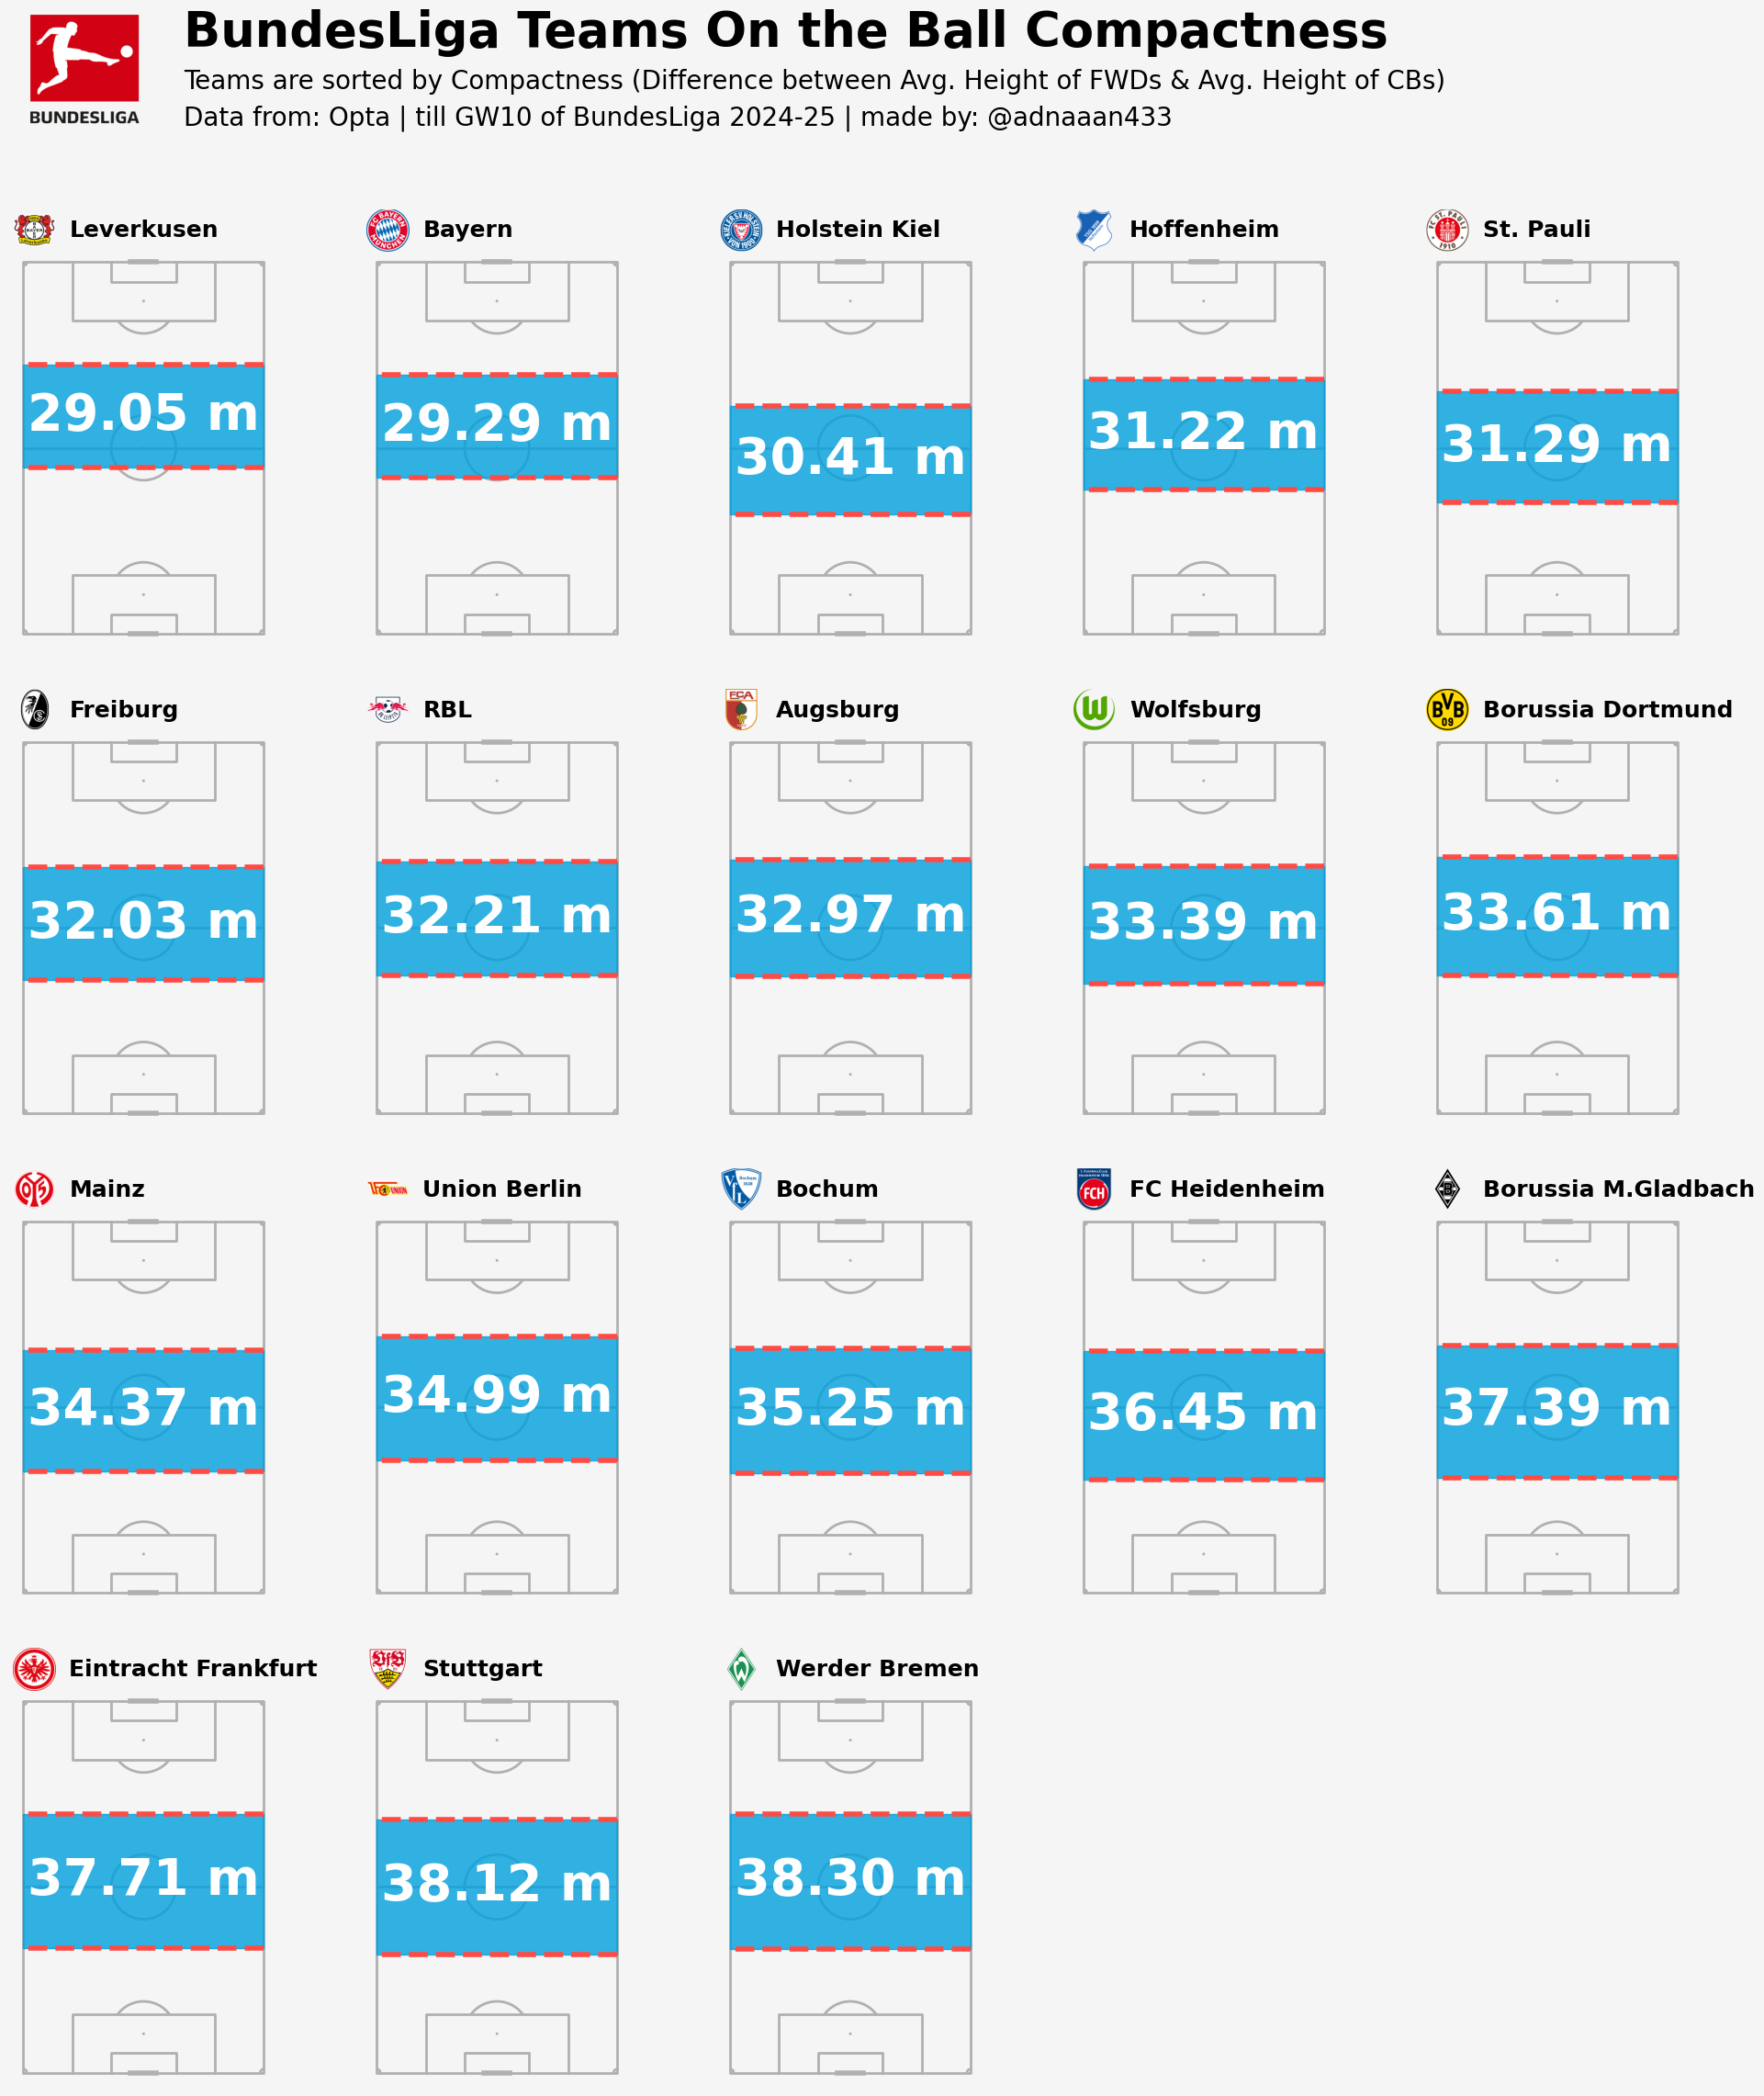

In [82]:
def calc_verticality(team_name):
    df_team = df[df['teamName']==team_name]
    match_ids = df_team['matchId'].unique()
    avg_h_data = {'matchId': match_ids, 'fwdh': [], 'defh': []}
    for mi in match_ids:
        df_m = df[df['matchId']==mi]
        # df_touch = df_m[(df_m['isTouch']==1) & (df_m['teamName']==team_name) & (df_m['isFirstEleven']==1) & (df_m['position']!='GK') &
        #                (~df_m['qualifiers'].str.contains('Freekick|Corner'))]
        df_touch = df_m[(df_m['type'].isin(['Pass', 'BallTouch', 'TakeOn', 'Dispossessed', 'Goal', 'SavedShot', 'MissedShots', 'ShotOnPost'])) & (df_m['teamName']==team_name) & (df_m['isFirstEleven']==1) & (df_m['position']!='GK') &
                       (~df_m['qualifiers'].str.contains('Freekick|Corner'))]
        df_touch = df_touch[['playerName', 'x', 'position']].reset_index(drop=True)
        avg_locs_df = df_touch.groupby('playerName').agg(avg_x=('x', 'median'), position=('position', 'first')).reset_index()
        avg_locs_df_top2 = avg_locs_df.sort_values(by='avg_x', ascending=False).head(2)
        fwdh = avg_locs_df_top2['avg_x'].mean()
        defh = avg_locs_df[avg_locs_df['position']=='DC']['avg_x'].median()
        avg_h_data['fwdh'].append(fwdh)
        avg_h_data['defh'].append(defh)
    
    avg_h_data = pd.DataFrame(avg_h_data)

    fx = avg_h_data['fwdh'].median()
    dx = avg_h_data['defh'].median()
    diff = fx-dx

    return diff

def plot_verticality(ax, team_name):
    pitch = VerticalPitch(pitch_type='uefa', pitch_color=bg_color, linewidth=2, corner_arcs=True)
    pitch.draw(ax=ax)
    df_team = df[df['teamName']==team_name]
    match_ids = df_team['matchId'].unique()
    avg_h_data = {'matchId': match_ids, 'fwdh': [], 'defh': []}
    for mi in match_ids:
        df_m = df[df['matchId']==mi]
        # df_touch = df_m[(df_m['isTouch']==1) & (df_m['teamName']==team_name) & (df_m['isFirstEleven']==1) & (df_m['position']!='GK') &
        #                (~df_m['qualifiers'].str.contains('Freekick|Corner'))]
        df_touch = df_m[(df_m['type'].isin(['Pass', 'BallTouch', 'TakeOn', 'Dispossessed', 'Goal', 'SavedShot', 'MissedShots', 'ShotOnPost'])) & (df_m['teamName']==team_name) & (df_m['isFirstEleven']==1) & (df_m['position']!='GK') &
                       (~df_m['qualifiers'].str.contains('Freekick|Corner'))]
        df_touch = df_touch[['playerName', 'x', 'position']].reset_index(drop=True)
        avg_locs_df = df_touch.groupby('playerName').agg(avg_x=('x', 'median'), position=('position', 'first')).reset_index()
        avg_locs_df_top2 = avg_locs_df.sort_values(by='avg_x', ascending=False).head(2)
        fwdh = avg_locs_df_top2['avg_x'].mean()
        defh = avg_locs_df[avg_locs_df['position']=='DC']['avg_x'].median()
        avg_h_data['fwdh'].append(fwdh)
        avg_h_data['defh'].append(defh)
    
    avg_h_data = pd.DataFrame(avg_h_data)

    fx = avg_h_data['fwdh'].median()
    dx = avg_h_data['defh'].median()
    diff = fx-dx

    ax.hlines(fx, xmin=0, xmax=68, color=col1, zorder=3, linewidth=4, linestyle='--')
    ax.hlines(dx, xmin=0, xmax=68, color=col1, zorder=3, linewidth=4, linestyle='--')
    fill_x = [0,68,68,0]
    fill_y = [dx,dx,fx,fx]
    ax.fill(fill_x, fill_y, color=col2, alpha=0.8)
    ax.text(34, ((fx+dx)/2), f'{diff:.2f} m', fontsize=40, color='w', fontweight='bold', ha='center', va='center')

    ax.text(55, 112, f'{team_name}', fontsize=18, fontweight='bold', ha='left')
    IMAGE_URL = f'file:///D:/FData/club_teams_logo/all_league%20-%20Copy/{team_name}.html'
    image = Image.open(urlopen(IMAGE_URL))
    ax_image = pitch.inset_image(114, 65, image, height=12, ax=ax)

# List of team names
team_names = df.teamName.unique()

# Create a DataFrame with team names and their diff values
team_avg_x = pd.DataFrame({'teamName': team_names})
team_avg_x['diff'] = team_avg_x['teamName'].apply(calc_verticality)

# Sort the teams by diff value
team_avg_x_sorted = team_avg_x.sort_values(by='diff', ascending=True).dropna().reset_index(drop=True)

# Create the figure and axes for a 4x5 grid
fig, axes = plt.subplots(nrows=4, ncols=5, figsize=(24, 26), facecolor=bg_color)

# Flatten the axes array to easily loop through it
axes = axes.ravel()

# Loop through the sorted team names and corresponding axes
for i, row in enumerate(team_avg_x_sorted.itertuples()):
    team_name = row.teamName
    diff = row.diff
    plot_verticality(axes[i], team_name)
plot_blank(axes[18])
plot_blank(axes[19])

fig.text(0.21, 0.98, 'BundesLiga Teams On the Ball Compactness', fontsize=38, fontweight='bold', ha='left', va='top')
fig.text(0.21, 0.955, "Teams are sorted by Compactness (Difference between Avg. Height of FWDs & Avg. Height of CBs)",
         fontsize=20, ha='left', va='top')
# fig_text(0.21, 0.94, "<Avg. Offensive Action Height of CenterBacks> | Overall Avg. Position of CneterBacks | <Avg. Defensive Action Height of CenterBacks>",
#          fontsize=17, ha='left', va='top', ax=fig, highlight_textprops=[{'color':col1}, {'color':col2}]_thin)
fig.text(0.21, 0.94, "Data from: Opta | till GW10 of BundesLiga 2024-25 | made by: @adnaaan433",
         fontsize=20, ha='left', va='top')

image_url = 'file:///D:/FData/Leagues_logos/Bundesliga_logo.html'
image = urlopen(image_url)
image = Image.open(image)
ax_image = add_image(image, fig, left=0.14, bottom=0.93, width=0.05, height=0.05)

# Turkish League

In [84]:
df = pd.read_csv(r"D:\FData\Tukish_League_2024_25\super_lig_24_25_event_data_till_gw12.csv")

In [85]:
def plot_blank(ax):
    pitch = VerticalPitch(pitch_type='uefa', pitch_color=bg_color, line_color=bg_color, linewidth=2, corner_arcs=True)
    pitch.draw(ax=ax)

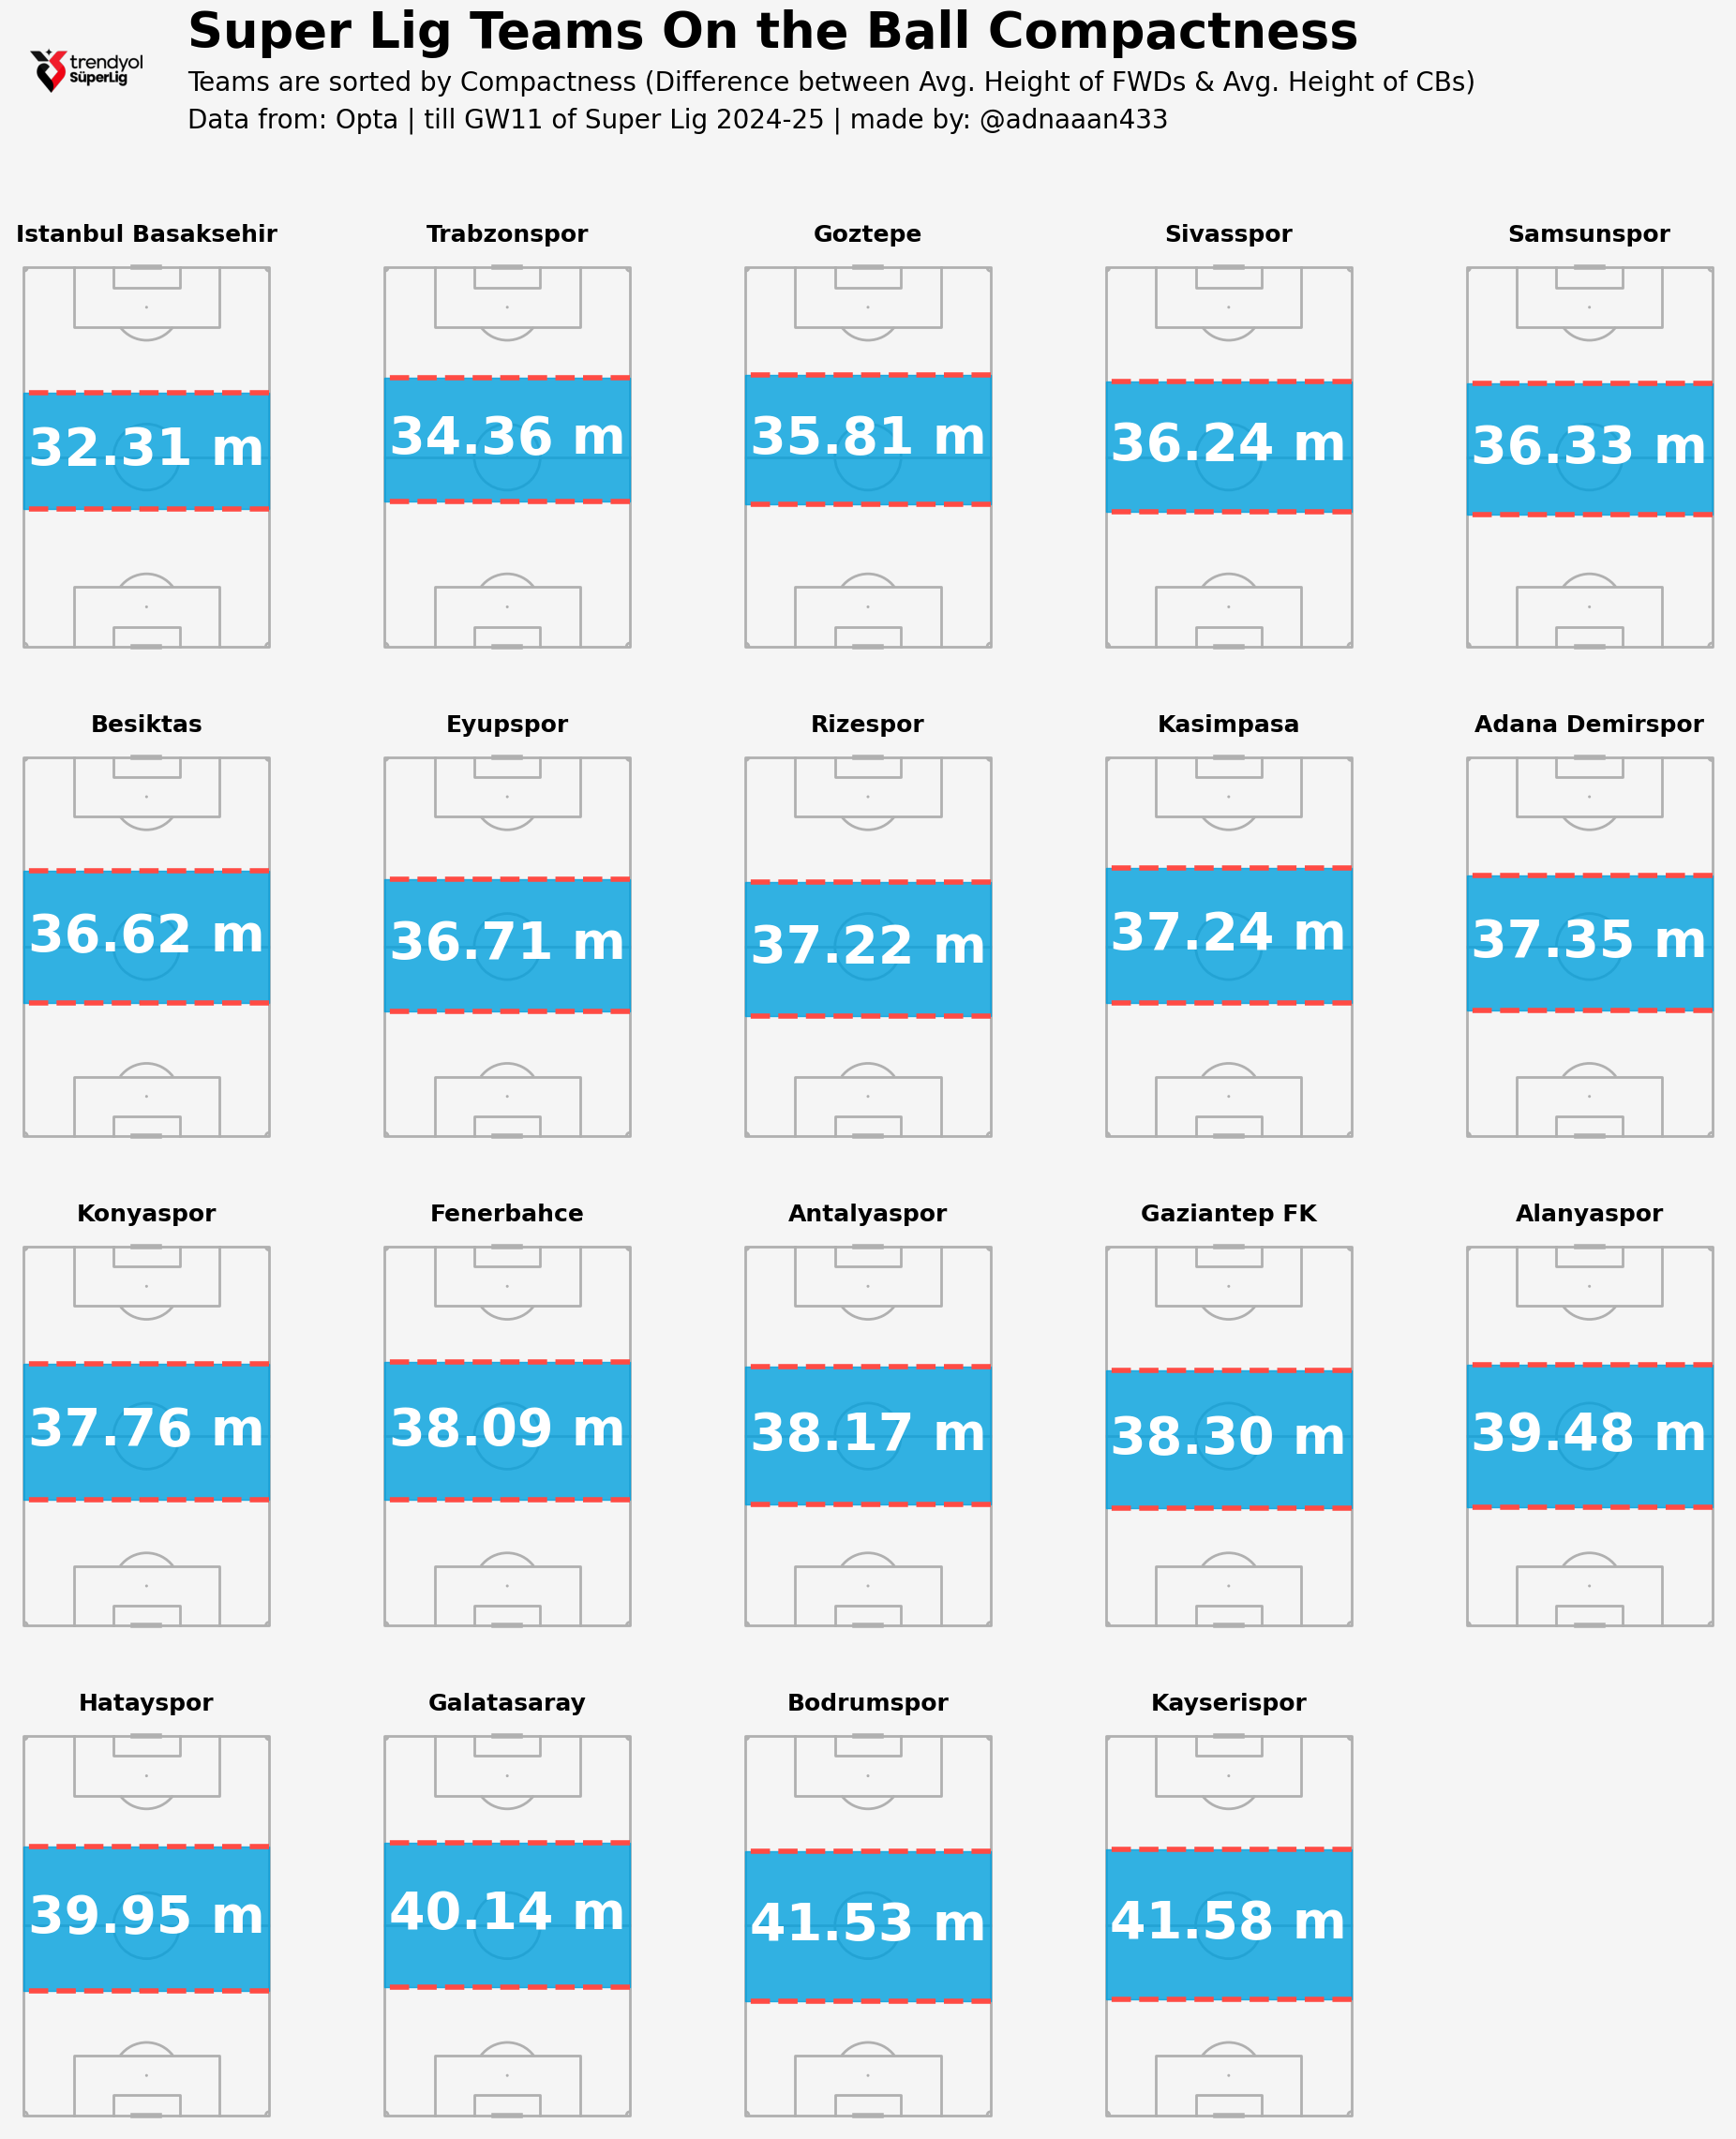

In [86]:
def calc_verticality(team_name):
    df_team = df[df['teamName']==team_name]
    match_ids = df_team['matchId'].unique()
    avg_h_data = {'matchId': match_ids, 'fwdh': [], 'defh': []}
    for mi in match_ids:
        df_m = df[df['matchId']==mi]
        # df_touch = df_m[(df_m['isTouch']==1) & (df_m['teamName']==team_name) & (df_m['isFirstEleven']==1) & (df_m['position']!='GK') &
        #                (~df_m['qualifiers'].str.contains('Freekick|Corner'))]
        df_touch = df_m[(df_m['type'].isin(['Pass', 'BallTouch', 'TakeOn', 'Dispossessed', 'Goal', 'SavedShot', 'MissedShots', 'ShotOnPost'])) & (df_m['teamName']==team_name) & (df_m['isFirstEleven']==1) & (df_m['position']!='GK') &
                       (~df_m['qualifiers'].str.contains('Freekick|Corner'))]
        df_touch = df_touch[['playerName', 'x', 'position']].reset_index(drop=True)
        avg_locs_df = df_touch.groupby('playerName').agg(avg_x=('x', 'median'), position=('position', 'first')).reset_index()
        avg_locs_df_top2 = avg_locs_df.sort_values(by='avg_x', ascending=False).head(2)
        fwdh = avg_locs_df_top2['avg_x'].mean()
        defh = avg_locs_df[avg_locs_df['position']=='DC']['avg_x'].median()
        avg_h_data['fwdh'].append(fwdh)
        avg_h_data['defh'].append(defh)
    
    avg_h_data = pd.DataFrame(avg_h_data)

    fx = avg_h_data['fwdh'].median()
    dx = avg_h_data['defh'].median()
    diff = fx-dx

    return diff

def plot_verticality(ax, team_name):
    pitch = VerticalPitch(pitch_type='uefa', pitch_color=bg_color, linewidth=2, corner_arcs=True)
    pitch.draw(ax=ax)
    df_team = df[df['teamName']==team_name]
    match_ids = df_team['matchId'].unique()
    avg_h_data = {'matchId': match_ids, 'fwdh': [], 'defh': []}
    for mi in match_ids:
        df_m = df[df['matchId']==mi]
        # df_touch = df_m[(df_m['isTouch']==1) & (df_m['teamName']==team_name) & (df_m['isFirstEleven']==1) & (df_m['position']!='GK') &
        #                (~df_m['qualifiers'].str.contains('Freekick|Corner'))]
        df_touch = df_m[(df_m['type'].isin(['Pass', 'BallTouch', 'TakeOn', 'Dispossessed', 'Goal', 'SavedShot', 'MissedShots', 'ShotOnPost'])) & (df_m['teamName']==team_name) & (df_m['isFirstEleven']==1) & (df_m['position']!='GK') &
                       (~df_m['qualifiers'].str.contains('Freekick|Corner'))]
        df_touch = df_touch[['playerName', 'x', 'position']].reset_index(drop=True)
        avg_locs_df = df_touch.groupby('playerName').agg(avg_x=('x', 'median'), position=('position', 'first')).reset_index()
        avg_locs_df_top2 = avg_locs_df.sort_values(by='avg_x', ascending=False).head(2)
        fwdh = avg_locs_df_top2['avg_x'].mean()
        defh = avg_locs_df[avg_locs_df['position']=='DC']['avg_x'].median()
        avg_h_data['fwdh'].append(fwdh)
        avg_h_data['defh'].append(defh)
    
    avg_h_data = pd.DataFrame(avg_h_data)

    fx = avg_h_data['fwdh'].median()
    dx = avg_h_data['defh'].median()
    diff = fx-dx

    ax.hlines(fx, xmin=0, xmax=68, color=col1, zorder=3, linewidth=4, linestyle='--')
    ax.hlines(dx, xmin=0, xmax=68, color=col1, zorder=3, linewidth=4, linestyle='--')
    fill_x = [0,68,68,0]
    fill_y = [dx,dx,fx,fx]
    ax.fill(fill_x, fill_y, color=col2, alpha=0.8)
    ax.text(34, ((fx+dx)/2), f'{diff:.2f} m', fontsize=40, color='w', fontweight='bold', ha='center', va='center')

    ax.text(34, 112, f'{team_name}', fontsize=18, fontweight='bold', ha='center')
    # IMAGE_URL = f'file:///D:/FData/club_teams_logo/all_league%20-%20Copy/{team_name}.html'
    # image = Image.open(urlopen(IMAGE_URL))
    # ax_image = pitch.inset_image(114, 65, image, height=12, ax=ax)

# List of team names
team_names = df.teamName.unique()

# Create a DataFrame with team names and their diff values
team_avg_x = pd.DataFrame({'teamName': team_names})
team_avg_x['diff'] = team_avg_x['teamName'].apply(calc_verticality)

# Sort the teams by diff value
team_avg_x_sorted = team_avg_x.sort_values(by='diff', ascending=True).dropna().reset_index(drop=True)

# Create the figure and axes for a 4x5 grid
fig, axes = plt.subplots(nrows=4, ncols=5, figsize=(24, 26), facecolor=bg_color)

# Flatten the axes array to easily loop through it
axes = axes.ravel()

# Loop through the sorted team names and corresponding axes
for i, row in enumerate(team_avg_x_sorted.itertuples()):
    team_name = row.teamName
    diff = row.diff
    plot_verticality(axes[i], team_name)
# plot_blank(axes[18])
plot_blank(axes[19])

fig.text(0.21, 0.98, 'Super Lig Teams On the Ball Compactness', fontsize=38, fontweight='bold', ha='left', va='top')
fig.text(0.21, 0.955, "Teams are sorted by Compactness (Difference between Avg. Height of FWDs & Avg. Height of CBs)",
         fontsize=20, ha='left', va='top')
# fig_text(0.21, 0.94, "<Avg. Offensive Action Height of CenterBacks> | Overall Avg. Position of CneterBacks | <Avg. Defensive Action Height of CenterBacks>",
#          fontsize=17, ha='left', va='top', ax=fig, highlight_textprops=[{'color':col1}, {'color':col2}]_thin)
fig.text(0.21, 0.94, "Data from: Opta | till GW11 of Super Lig 2024-25 | made by: @adnaaan433",
         fontsize=20, ha='left', va='top')

image_url = 'file:///D:/FData/Leagues_logos/S%C3%BCperLig_Logo.html'
image = urlopen(image_url)
image = Image.open(image)
ax_image = add_image(image, fig, left=0.14, bottom=0.93, width=0.05, height=0.05)